## Importing relevant libraries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import execute
from qiskit import transpiler
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate
from qiskit.circuit.reset import Reset
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library.standard_gates import IGate, UGate, U3Gate
from qiskit.dagcircuit import DAGOpNode, DAGInNode
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.transpiler.passes.optimization import Optimize1qGates
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from math import fsum
from scipy.optimize import minimize
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.providers.models import BackendConfiguration
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.passes import BasisTranslator
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.circuit import Delay
from qiskit.circuit.library import XGate, YGate, ZGate, RXGate, RYGate, RZGate
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.providers.fake_provider import FakeMontreal
from qiskit.providers.fake_provider import FakeJakarta
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.providers.fake_provider import FakeHanoi
from qiskit.providers.fake_provider import FakeLagos
from qiskit.providers.fake_provider import FakeMelbourne
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.providers.fake_provider import FakeToronto
from qiskit.providers.fake_provider import FakeWashington
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer import AerSimulator

# Import Paddle libraries
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

C:\Users\abc\AppData\Local\Temp\ipykernel_15904\3355370929.py:28: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
C:\Users\abc\anaconda3\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy

## Constructing the FPE operator and implementing helper functions

In [2]:
## Classical implementation
"""
Purpose: 
    Find the analytical solution given the input parameters
Input: 
    x: array representing the x coordinates over which the solution is to be found
    a, Γ: parameters for the Ornstein-Uhlenbeck equation
Output:
    y: array of the value of the analytical solution over x
"""

def OrnsteinUhlenbeck(x, a = 1, gamma = 1):
    y = np.sqrt(a/(2*np.pi*gamma)) * np.exp((-a * x ** 2)/(2*gamma))
    
    return y

"""
Purpose:
    Calculate the weighted Hermite polynomials using recursive relations up to H_n
Input:
    n: the highest number of Hermite polynomials to be evaluated at
    x: the value of x at which the weighted Hermite polynomials are to be evaluated
Output:
    Hermite: the value of the weighted Hermite polynomials
Example: HermiteSeries(2, 4) -> [H_0(4), H_1(4), H_2(4)]
"""

def HermiteSeries(n, x):
    Hermite = np.zeros((1, n+1))
    Hermite[0][0] = 1.0 * np.exp(-x**2/2)
    Hermite[0][1] = 2.0 * x *np.exp(-x**2/2)
    
    for ni in range(1, n):
        Hermite[0][ni+1] = 2*x*Hermite[0][ni] - 2*ni*Hermite[0][ni-1]
    
    return Hermite

"""
Purpose:
    Reconstruct the functions represented by the coefficients of weighted Hermite polynomials in spatial coordinates
Input:
    x: array containing the x values over which the function is to be evaluated
    coefficients: the coefficients corresponding to the Hermite polynomials (should be zero-mode of the operator)
    nmax: the highest order of weighted Hermite polynomials used
    s: the scaling factor
Output:
    y: the reconstruction
"""

def project(x, coefficients, nmax, s):
    
    y = np.zeros(x.shape)
    
    for i in (range(len(x))):
        x0 = s*x[i]
        hermite_values = HermiteSeries(nmax, x0)
        y[i] += np.dot(hermite_values, coefficients)
        
    return (x, y)

"""
Purpose:
    Normalize the PDF so that the area under the curve is 1
Input:
    x, y: arrays representing the unnormalized
Output:
    (x, y): normalized PDF
"""

def normalize(x, y):
    dx = x[1] - x[0]
    sum = 0
    
    for i in range(len(x)):
        sum = sum + (y[i] * dx)
    
    y = y/sum
    
    return (x, y)

"""
Purpose:
    Calculate the RMS
Input:
    y_op, y: the y values generated by the operator and the analytical solution
Output:
    RMS
"""

def rms_diff(y_op, y):
    return np.sqrt(np.sum((y_op-y)**2)/len(y))

"""
Purpose:
    Find s given a and Γ such that the projection in Hermite space is just H_0
Input:
    a, Γ: parameters for Ornstein-Uhlenbeck
Output:
    s
"""

def special_s(a, gamma):
    return np.sqrt(a/gamma)

def euler_representation(z):
    A = abs(z)
    phase = math.atan(z.imag/z.real)
    
    return A, phase

def generate_positive_semidefinite_matrix(eigenvalues):
    ## Function to transform the FPE operator to the Hermite basis and return a finite truncated matrix for the ...
    ## ... FPE operator
    
    n = len(eigenvalues)
    s = np.diag(eigenvalues)
    q, _ = la.qr(np.random.rand(n, n))
    semidef = np.dot(np.transpose(q), s)
    semidef = np.dot(semidef, q)
    
    return semidef

def normalize_probability(y, dx):
    ## Function to return a normalized PDF 
    
    total = np.sum(y) * dx
    y = y / total
    
    return y

def perturbed_ornstein_uhlenbeck(x0, a = 1, gamma = 1, c = 0, shift = 0):
    ## Function to compute the exact solution to the perturbed Ornstein-Uhlenbeck equation
    
    assert len(x0) > 1, "Error: x0 should be a vector"

    x = x0 - shift
    y = np.exp(-a*x**2 /(2*gamma) - c*x**4 /(4*gamma))
    dx = x[2] - x[1]
    
    y = normalize_probability(y, dx)
    
    return y

def special_L(a, gamma):
    ## Function to compute the characteristic length scale
    
    return np.sqrt(a/gamma)

def delta(N, n):
    ## Function to implement the Kronecker delta function
    
    if N == n:
        return 1
    else:
        return 0

def f(N,n):
    return 0.5*( np.sqrt(n*(n-1))*delta(N,n-2) + delta(N,n) - np.sqrt((n+1)*(n+2))*delta(N,n+2))

def g(N,n, L):
    return 0.5*L**2*( np.sqrt(n*(n-1))*delta(N,n-2) - (2*n+1)*delta(N,n) + np.sqrt((n+1)*(n+2))*delta(N,n+2))

def t(N, n, L):
    val1 = np.sqrt(n*(n-1)*(n-2)*(n-3))*delta(N, n-4)
    val2 = (2*n+2)*np.sqrt(n*(n-1))*delta(N, n-2)
    val3 = (6*n+3)*delta(N, n)
    val4 = -2*n*np.sqrt((n+1)*(n+2))*delta(N, n+2)
    val5 = -1*np.sqrt((n+1)*(n+2)*(n+3)*(n+4))*delta(N, n+4)

    return 1/(4*L**2)*( val1 + val2 + val3 + val4 + val5 )

def element_perturbed(N, n, L, a, c, gamma):
    ## Function to compute the matrix elements of the finite truncated matrix for the FPE operator (in the Hermite basis)
    
    return -(a*f(N,n) + c*t(N, n, L) + gamma*g(N, n, L))

def create_operator_perturbed(nmax, L, a, c, gamma):
    ## Function to generate the FPE operator matrix in the Hermite basis
    op = np.zeros((nmax+1, nmax+1))
    
    for N in range(nmax+1):
        row = N
        for n in range(nmax+1):
            col = n
            op[row, col] = element_perturbed(N, n, L, a, c, gamma)
    
    """
    if np.any(np.nan, op):
        print("There's an nan in the operator")
    elif np.any(np.inf, op):
        print("There is an inf in the operator")
    """

    return op

def state_n(nmax, x0, L):
    ## Function to compute the Hermite polynomials upto the order specified by nmax
    
    assert L > 0, "Error (state_n): input L must be greater than or equal to 0"

    states = np.zeros(nmax + 1)
    x = x0*L

    states[0] = np.sqrt(L*np.sqrt(1/np.pi))* 1.0 * np.exp(-x**2/2)

    if nmax > 0:
        states[1] = np.sqrt(L*np.sqrt(1/np.pi))* (1/np.sqrt(2)) * 2.0 * x * np.exp(-(x**2)/2)
    
    for ni in range(2, nmax + 1):
        states[ni] = ((np.sqrt(2)*x) / np.sqrt(ni))*states[ni-1] - (ni-1)/np.sqrt((ni)*(ni-1))*states[ni-2]

    return states

def integrate_eigenvector(x0, y, nmax, L):
    ## Function to compute the coefficients corresponding to the calculated Hermite polynomials by numerical integration
    ## Note: here, we use the left-hand integration method
    
    dx = x0[2] - x0[1]
    eigenvector = np.zeros(nmax + 1)

    for i in range(len(x)):

        states = state_n(nmax, x0[i], L)
        states = states * y[i] * dx

        eigenvector = eigenvector + states
        
    return {"eigenvector" : eigenvector, "dx" : dx, "nmax" : nmax, "x0" : x0, "L" : L}

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))
    
    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]
    
    return op_new

def reconstruct_eigenvector(cache, normalize = True, only_even = False):
    ## Function to reconstruct the PDF using the cache obtained previously
    
    eigenvector = cache["eigenvector"]
    nmax = cache["nmax"]
    x0 = cache["x0"]
    dx = cache["dx"]
    L = cache["L"]
    
    if not only_even:
        eigenvector = cache["eigenvector"]
    else:
        eigenvector_old = cache["eigenvector"]
        eigenvector = np.zeros(nmax + 1)
        
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]

    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    if normalize:   
        y = normalize_probability(y, dx)
        
    return (x0, y)

def find_zeromode(op_nonhermitian, nmax, x0, dx, L, which = "single", only_even = False):
    ## Function to compute the zeromode, its position, and the eigenvalue corresponding to the zeromode
    
    assert which == "nonhermitian" or which == "single", "Error: currently only supports which = {\"nonhermitian\", \"single\"}"
    
    if only_even:
        op_processed = make_operator_even(op_nonhermitian)
    else:
        op_processed = op_nonhermitian
        
    if which == "nonhermitian":
        op = op_processed
    elif which == "single":
        op = np.dot(np.transpose(op_processed), op_processed)

    eigenvalues, eigenvectors = la.eig(op)

    index = np.argmin(np.real(eigenvalues)**2)

    min_eigenval = eigenvalues[index]
    
    zeromode = eigenvectors[:, index]

    return {"operator" : op, "which" : which, \
            "eigenvector" : np.real(zeromode), "index" : index, "eigenvalue" : np.real(min_eigenval), \
            "nmax" : nmax, "x0" : x0, "dx" : dx, "L" : L, "spectrum" : eigenvalues, "P" : eigenvectors}

def rms_diff(y0, y, sigdigits = 0):
    ## Function to compute the RMS difference between the analytically computed PDF and the one ...
    ## ... obtained using the FPE operator
    
    assert len(y0) == len(y), "Error: the length of y0 and y should be the same"
    diff = np.sum((y0-y)**2)/len(y0)
    
    return np.sqrt(diff)

def analyze_collapse(initial_state, P, index):
    num_basis = P.shape[1]
    coefficients = np.zeros((num_basis, ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        coefficients[i] = np.dot(basis, initial_state)

    normalized_coefficients = normalize_eigenvector(coefficients)

    reconstruction = np.zeros((P.shape[0], ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        added_vector = coefficients[i] * basis
        reconstruction = reconstruction + added_vector

    probability = normalized_coefficients ** 2
    
    probability_zeromode = probability[index]
    assert np.sum(probability) - 1 < 0.00001, "Error: unity normalization of probability is not observed"

    print("The initial_state is: ")
    print(initial_state)
    print()

    print("The coefficient expansion is: ")
    print(coefficients)
    print()

    print("The normalized coefficient expansion is: ")
    print(normalized_coefficients)
    print()

    print("The reconstructed vector is: ")
    print(reconstruction)
    print()

    print("The probability of collapsing into each eigenvector is: ")
    print(probability)
    print()

    print("The probability of collapsing into the zeromode is: ")
    print(probability_zeromode)
    print()
    
    return probability_zeromode, probability

## Saving IBMQ account

In [3]:
IBMQ.save_account('20679dd22551941f9255655deabc9d69d569091c01ec92bdb01c2999ac7c55e771b66be79444a46d21a51f3a6894c01f6485b9692ef9d620849186b8e67964cf')

C:\Users\abc\AppData\Local\Temp\ipykernel_15904\2708008332.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('20679dd22551941f9255655deabc9d69d569091c01ec92bdb01c2999ac7c55e771b66be79444a46d21a51f3a6894c01f6485b9692ef9d620849186b8e67964cf')
configrc.store_credentials:WARNING:2024-04-14 12:11:26,250: Credentials already present. Set overwrite=True to overwrite.


## Loading IBMQ account

In [4]:
IBMQ.load_account()

__init__.discover_credentials:INFO:2024-04-14 12:11:26,277: Using credentials from qiskitrc


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Importing IBMQ provider

In [5]:
provider = IBMQ.get_provider('ibm-q')

## Printing available backends

In [6]:
available_cloud_backends = provider.backends() 
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)

available_local_backends = Aer.backends() 
print('\nHere is the list of local backends that are available to you: ')
for i in available_local_backends: print(i)

INFO 2024-04-14 12:11:28,878 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,882 assembler.py:38] Total Assembly Time - 1.01328 (ms)
INFO 2024-04-14 12:11:28,884 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,887 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,890 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,892 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,894 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,897 assembler.py:38] Total Assembly Time - 0.28706 (ms)
INFO 2024-04-14 12:11:28,900 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,902 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,904 assembler.py:38] Total Assembly Time - 1.00660 (ms)
INFO 2024-04-14 12:11:28,907 assembler.py:38] Total Assembly Time - 0.00000 (ms)
INFO 2024-04-14 12:11:28,907


Here is the list of cloud backends that are available to you:
ibmq_qasm_simulator
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibm_brisbane
ibm_kyoto
ibm_osaka

Here is the list of local backends that are available to you: 
aer_simulator
aer_simulator_statevector
aer_simulator_density_matrix
aer_simulator_stabilizer
aer_simulator_matrix_product_state
aer_simulator_extended_stabilizer
aer_simulator_unitary
aer_simulator_superop
qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator


C:\Users\abc\anaconda3\lib\site-packages\qiskit_aer\aerprovider.py:86: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backends.append(backend_cls(**opts))


## QPE circuit construction

In [7]:
## QPE implementation (for running quantum simulations)

def inverse_qft(qc, precision_qubits, with_inverse_barriers = True, swap = True):
    """
    Purpose: Implements inverse QFT
    Input: qc -> circuit to append the inverse QFT circuit to
           precision_qubits -> Implement
    """
    n = len(precision_qubits)
    
    if swap:
        for qubit in range(n//2):
            qc.swap(precision_qubits[qubit], precision_qubits[n - qubit - 1])
    if with_inverse_barriers:
        qc.barrier() ## for visualization purposes
    
    for target in reversed(range(n)):
        for control in reversed(range(target + 1, n)):
            k = control - target + 1
            angle = -2 * math.pi/(2**k)
            qc.cp(angle, precision_qubits[control], precision_qubits[target], label = f"R_{k}_dag") ## apply controlled phase gates
        qc.h(precision_qubits[target])
        
        if with_inverse_barriers and target != 0:
            qc.barrier() ## for visualization purposes
        
def controlled_unitary(circ, control, target_qubits, unitary):
    """
    Purpose: Implement controlled unitary gate
    Input: circ -> circuit to append the controlled unitary onto
           control -> List containing the control qubit
           target_qubits -> List containing the target qubits
           unitary -> Numpy array representing unitary matrix that will be turned into a gate
    Output: circ -> circuit with the the controlled unitary gate
    """
    U_gate = UnitaryGate(unitary)
    U_gate_ctrl = U_gate.control(1)
    targets = [control] + target_qubits
    circ.append(U_gate_ctrl, targets)
    
def qpe_without_DD(qpe_circ, precision_qubits, query_qubits, unitary, angles = None, control_unitary = True, \
                  with_inverse_barriers = True, measure = True):
    """
    Purpose: Construct the QPE circuit for a specific unitary operator without applying DD to the circuit
    Input: precision_qubits -> List containing the precision qubits
           query_qubits -> List containing the query qubits
           unitary -> the unitary operator used for the QPE
           control_unitary -> Boolean value representing the implementation of controlled unitary in each iteration.
                              Default is True, meaning that the power to the unitary operator is found, thus reducing
                              the number of gates needed.
    Output: qpe_circ -> the QPE Circuit
    """
    num_precision_qubits = len(precision_qubits)
    num_query_qubits = len(query_qubits)
    total_qubits = num_precision_qubits + num_query_qubits
    
    ## Apply Hadamard gates to all precision qubits
    qpe_circ.h(precision_qubits)
    
    if isinstance(angles, np.ndarray):
        assert len(angles) == len(query_qubits)
        for i in range(len(query_qubits)):
            if angles[i] != 0:
                qpe_circ.ry(angles[i] * 2, len(query_qubits) + len(precision_qubits) - 1 - i)
                
    for ii, qubit in enumerate(reversed(precision_qubits)):
        power = ii
        if control_unitary: 
            Uexp = np.linalg.matrix_power(unitary, 2 ** power)
            controlled_unitary(qpe_circ, qubit, query_qubits, Uexp)
        
        else:
            for _ in range(2 ** power):
                # Apply controlled unitary operations
                controlled_unitary(qpe_circ, qubit, query_qubits, unitary)
                
    qpe_circ.barrier()  # for visualization purposes
    inverse_qft(qpe_circ, precision_qubits, with_inverse_barriers = with_inverse_barriers)
    qpe_circ.barrier()  # for visualization purposes
    
    ## Add measurements
    if measure:
        for n in range(total_qubits):
            qpe_circ.measure(n, n)
    
################################################################################################################################
# The following functions implement different versions of the QPE circuit
# Refer Dingding Wei's senior thesis for more details
            
def mqpe(circ, unitary, precision_number, query_number, precision_verification_factor, query_verification_factor, \
        control_unitary = True, with_inverse_barriers = True, measure = True):
    
    num_precision_qubits = precision_number * precision_verification_factor
    num_query_qubits = query_number * query_verification_factor
    total_qubits = num_precision_qubits + num_query_qubits
    
    ## Initializing lists containing the precision and query qubits
    precision_qubits = list(np.arange(0, num_precision_qubits, precision_verification_factor))
    query_qubits = list(np.arange(num_precision_qubits, total_qubits, query_verification_factor))
    
    ## Applying the Quantum Phase Estimation algorithm
    qpe_without_DD(circ, precision_qubits, query_qubits, unitary, control_unitary = control_unitary, \
       with_inverse_barriers = with_inverse_barriers, measure = False)
    
    circ.barrier() ## for visualization purposes
    
    ## Adding relevant gates for post-processing
    for control in precision_qubits:
        for j in range(1, precision_verification_factor):
            circ.cx(control, control + j)
            
    circ.barrier() ## for visualization purposes
    
    for control in query_qubits:
        for j in range(1, query_verification_factor):
            circ.cx(control, control + j)
            
    circ.barrier() ## for visualization purposes
    
    ## Adding measurements
    if measure:
        for n in range(total_qubits):
            circ.measure(n, n)

def mqpe2(circ, unitary, precision_number, query_number, precision_verification_factor, query_verification_factor, \
         control_unitary = True, with_inverse_barriers = True, measure = True, \
         measure_post_first_iter = True, measure_all_post_first = False, min_power = 0, with_toffoli = False):
    
    ## Implement a check condition to ensure query verification exists 
    if measure_post_first_iter:
        assert query_verification_factor > 1, "Cannot measure_post_first_iter if there is no query verification"
        
    num_precision_qubits = precision_number * precision_verification_factor
    num_query_qubits = query_number * query_verification_factor
    total_qubits = num_precision_qubits + num_query_qubits
    
    ## Initializing lists containing the precision and query qubits
    precision_qubits = list(np.arange(0, num_precision_qubits, precision_verification_factor))
    query_qubits = list(np.arange(num_precision_qubits, total_qubits, query_verification_factor))
    
    ## Add Hadamard gates to all precision qubits
    circ.h(precision_qubits) # note: precision_qubits is a list
    
    ## Apply controlled unitary operations and add relevant gates for post-processing
    for ii, qubit in enumerate(precision_qubits):
        power = ii + min_power
        
        if control_unitary:
            Uexp = np.linalg.matrix_power(unitary, 2 ** power)
            controlled_unitary(circ, qubit, query_qubits, Uexp)   
        
        else:
            for _ in range(2**power):
                controlled_unitary(circ, qubit, query_qubits, unitary)
                
        if power == 0 and measure_post_first_iter:
            if measure_all_post_first:
                for control in query_qubits:
                    if with_toffoli:
                        circ.toffoli(qubit, control, control + j)
                    else:
                        circ.cx(control, control + j)
                        
            else:
                for control in query_qubits:
                    if with_toffoli:
                        circ.toffoli(qubit, control, control + 1)
                    else:
                        circ.cx(control, control + 1)
                        
        if measure_post_first_iter:
            if not measure_all_post_first:
                for control in query_qubits:
                    for j in range(2, query_verification_factor):
                        if with_toffoli:
                            circ.toffoli(precision_qubits[-1], control, control + j)
                        else:
                            circ.cx(control, control + j)
        else:
            for control in query_qubits:
                for j in range(1, query_verification_factor):
                    if with_toffoli:
                        circ.toffoli(precision_qubits[-1], control, control + j)
                    else:
                        circ.cx(control, control + j)
        
        ## Applying the inverse QFT to the circuit
        inverse_qft(circ, precision_qubits, with_inverse_barriers = with_inverse_barriers, swap = False)
        
        for control in precision_qubits:
            for j in range(1, query_verification_factor):
                circ.cx(control, control + j)
        
        circ.barrier() ## for visualization purposes
        
        ## Adding measurements
        if measure:
            for n in range(total_qubits):
                circ.measure(n, n)
                
def mqpe3(circ, unitary, precision_number, query_number, precision_verification_factor, query_verification_factor, \
         control_unitary = True, with_inverse_barriers = True, measure = True, measure_post_first_iter = True):
    
    ## Implement a check condition to ensure query verification exists 
    if measure_post_first_iter:
        assert query_verification_factor > 1, "Cannot measure_post_first_iter if there is no query verification"
        
    num_precision_qubits = precision_number * precision_verification_factor
    num_query_qubits = query_number * query_verification_factor
    total_qubits = num_precision_qubits + num_query_qubits
    
    ## Initializing lists containing the precision and query qubits
    precision_qubits = list(np.arange(0, num_precision_qubits, precision_verification_factor))
    query_qubits = list(np.arange(num_precision_qubits, total_qubits, query_verification_factor))
    
    ## Add Hadamard gates to all precision qubits
    circ.h(precision_qubits) # note: precision_qubits is a list
    
    for ii, qubit in enumerate(precision_qubits):
        power = ii
        
        if control_unitary:
            Uexp = np.linalg.matrix_power(unitary, 2 ** power)
            controlled_unitary(circ, qubit, query_qubits, Uexp)
        else:
            for _ in range(2 ** power):
                controlled_unitary(circ, qubit, query_qubits, unitary)
        
        if power == 0 and measure_post_first_iter:
            for control in query_qubits:
                for j in range(1, query_verification_factor):
                    circ.cx(control, control + j)
    
    circ.barrier() ## for visualization purposes
    
    ## Applying inverse QFT to the circuit
    inverse_qft(circ, precision_qubits, with_inverse_barriers = with_inverse_barriers, swap = False)
    
    circ.barrier() ## for visualization purposes
    
    for control in precision_qubits:
        for j in range(1, precision_verification_factor):
            circ.cx(control, control + j)
    
    if not measure_post_first_iter:
        for control in query_qubits:
            for j in range(1, precision_verification_factor):
                circ.cx(control, control + j)
    
    circ.barrier() ## for visualization purposes
    
    ## Add measurements
    if measure:
        for n in range(total_qubits):
            circ.measure(n, n)

## Implementing controlled unitary gate operations

In [8]:
def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)
    
    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

def get_qubits(n_precision_qubits, n_query_qubits):
    """
    Purpose: defines the precision and query qubits
    Input: n_precision_qubits -> the number of precision qubits used by the QPE
           n_query_qubits -> the number of query qubits used by the QPE
    """
    total_qubits = list(range(n_precision_qubits + n_query_qubits))

    precision_qubits = total_qubits[0:n_precision_qubits]
    query_qubits = total_qubits[n_precision_qubits:]

    return precision_qubits, query_qubits

def unitary_swap(num_query_qubits, state1, state2):
    U = np.eye(2**num_query_qubits)
    
    temp = np.copy(U[:, state1])
    U[:, state1] = U[:, state2]
    U[:, state2] = temp
    
    return U

## Implementing dynamical decoupling (note: not relevant for the present study)

In [9]:
class DynamicalDecoupling(TransformationPass):
    """Dynamical decoupling insertion pass.

    This pass works on a scheduled, physical circuit. It scans the circuit for
    idle periods of time (i.e. those containing delay instructions) and inserts
    a DD sequence of gates in those spots. These gates amount to the identity,
    so do not alter the logical action of the circuit, but have the effect of
    mitigating decoherence in those idle periods.

    As a special case, the pass allows a length-1 sequence (e.g. [XGate()]).
    In this case the DD insertion happens only when the gate inverse can be
    absorbed into a neighboring gate in the circuit (so we would still be
    replacing Delay with something that is equivalent to the identity).
    This can be used, for instance, as a Hahn echo.

    This pass ensures that the inserted sequence preserves the circuit exactly
    (including global phase).

    .. jupyter-execute::

        import numpy as np
        from qiskit.circuit import QuantumCircuit
        from qiskit.circuit.library import XGate
        from qiskit.transpiler import PassManager, InstructionDurations
        from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
        from qiskit.visualization import timeline_drawer
        circ = QuantumCircuit(4)
        circ.h(0)
        circ.cx(0, 1)
        circ.cx(1, 2)
        circ.cx(2, 3)
        circ.measure_all()
        durations = InstructionDurations(
            [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
             ("cx", [1, 2], 200), ("cx", [2, 3], 300),
             ("x", None, 50), ("measure", None, 1000)]
        )

    .. jupyter-execute::

        # balanced X-X sequence on all qubits
        dd_sequence = [XGate(), XGate()]
        pm = PassManager([ALAPSchedule(durations),
                          DynamicalDecoupling(durations, dd_sequence)])
        circ_dd = pm.run(circ)
        timeline_drawer(circ_dd)

    .. jupyter-execute::

        # Uhrig sequence on qubit 0
        n = 8
        dd_sequence = [XGate()] * n
        def uhrig_pulse_location(k):
            return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
        spacing = []
        for k in range(n):
            spacing.append(uhrig_pulse_location(k) - sum(spacing))
        spacing.append(1 - sum(spacing))
        pm = PassManager(
            [
                ALAPSchedule(durations),
                DynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
            ]
        )
        circ_dd = pm.run(circ)
        timeline_drawer(circ_dd)
    """

    def __init__(self, durations, dd_sequence, name=None, qubits=None, spacing=None, skip_reset_qubits=True):
        """Dynamical decoupling initializer.

        Args:
            durations (InstructionDurations): Durations of instructions to be
                used in scheduling.
            dd_sequence (list[Gate]): sequence of gates to apply in idle spots.
            qubits (list[int]): physical qubits on which to apply DD.
                If None, all qubits will undergo DD (when possible).
            spacing (list[float]): a list of spacings between the DD gates.
                The available slack will be divided according to this.
                The list length must be one more than the length of dd_sequence,
                and the elements must sum to 1. If None, a balanced spacing
                will be used [d/2, d, d, ..., d, d, d/2].
            skip_reset_qubits (bool): if True, does not insert DD on idle
                periods that immediately follow initialized/reset qubits (as
                qubits in the ground state are less susceptile to decoherence).
        """
        super().__init__()
        self._durations = durations
        self._dd_sequence = dd_sequence
        self._qubits = qubits
        self._spacing = spacing
        self._skip_reset_qubits = skip_reset_qubits
        self._if_DD = False
        self._name = name

    def run(self, dag):
        """Run the DynamicalDecoupling pass on dag.

        Args:
            dag (DAGCircuit): a scheduled DAG.

        Returns:
            DAGCircuit: equivalent circuit with delays interrupted by DD,
                where possible.

        Raises:
            TranspilerError: if the circuit is not mapped on physical qubits.
        """
        if len(dag.qregs) != 1 or dag.qregs.get("q", None) is None:
            raise TranspilerError("DD runs on physical circuits only.")

        if dag.duration is None:
            raise TranspilerError("DD runs after circuit is scheduled.")

        num_pulses = len(self._dd_sequence)
        sequence_gphase = 0
        if num_pulses != 1:
            if num_pulses % 2 != 0:
                raise TranspilerError("DD sequence must contain an even number of gates (or 1).")
            noop = np.eye(2)
            for gate in self._dd_sequence:
                noop = noop.dot(gate.to_matrix())
            if not matrix_equal(noop, IGate().to_matrix(), ignore_phase=True):
                raise TranspilerError("The DD sequence does not make an identity operation.")
            sequence_gphase = np.angle(noop[0][0])

        if self._qubits is None:
            self._qubits = set(range(dag.num_qubits()))
        else:
            self._qubits = set(self._qubits)

        if self._spacing:
            if fsum(self._spacing) != 1 or any(a < 0 for a in self._spacing):
                raise TranspilerError(
                    "The spacings must be given in terms of fractions "
                    "of the slack period and sum to 1."
                )
        else:  # default to balanced spacing
            mid = 1 / num_pulses
            end = mid / 2
            self._spacing = [end] + [mid] * (num_pulses - 1) + [end]

        new_dag = dag._copy_circuit_metadata()

        qubit_index_map = {qubit: index for index, qubit in enumerate(new_dag.qubits)}
        index_sequence_duration_map = {}
        for qubit in new_dag.qubits:
            physical_qubit = qubit_index_map[qubit]
            dd_sequence_duration = 0
            for gate in self._dd_sequence:
                gate.duration = self._durations.get(gate, physical_qubit)
                dd_sequence_duration += gate.duration
            index_sequence_duration_map[physical_qubit] = dd_sequence_duration

        for nd in dag.topological_op_nodes():
            if not isinstance(nd.op, Delay):
                new_dag.apply_operation_back(nd.op, nd.qargs, nd.cargs)
                continue

            dag_qubit = nd.qargs[0]
            physical_qubit = qubit_index_map[dag_qubit]
            if physical_qubit not in self._qubits:  # skip unwanted qubits
                new_dag.apply_operation_back(nd.op, nd.qargs, nd.cargs)
                continue

            pred = next(dag.predecessors(nd))
            succ = next(dag.successors(nd))
            if self._skip_reset_qubits:  # discount initial delays
                if isinstance(pred, DAGInNode) or isinstance(pred.op, Reset):
                    new_dag.apply_operation_back(nd.op, nd.qargs, nd.cargs)
                    continue

            dd_sequence_duration = index_sequence_duration_map[physical_qubit]
            slack = nd.op.duration - dd_sequence_duration
            if slack <= 0:  # dd doesn't fit
                new_dag.apply_operation_back(nd.op, nd.qargs, nd.cargs)
                continue

            if num_pulses == 1:  # special case of using a single gate for DD
                u_inv = self._dd_sequence[0].inverse().to_matrix()
                theta, phi, lam, phase = OneQubitEulerDecomposer().angles_and_phase(u_inv)
                # absorb the inverse into the successor (from left in circuit)
                if isinstance(succ, DAGOpNode) and isinstance(succ.op, (UGate, U3Gate)):
                    theta_r, phi_r, lam_r = succ.op.params
                    succ.op.params = Optimize1qGates.compose_u3(
                        theta_r, phi_r, lam_r, theta, phi, lam
                    )
                    sequence_gphase += phase
                    self._if_DD = True
                # absorb the inverse into the predecessor (from right in circuit)
                elif isinstance(pred, DAGOpNode) and isinstance(pred.op, (UGate, U3Gate)):
                    theta_l, phi_l, lam_l = pred.op.params
                    pred.op.params = Optimize1qGates.compose_u3(
                        theta, phi, lam, theta_l, phi_l, lam_l
                    )
                    sequence_gphase += phase
                    self._if_DD = True
                # don't do anything if there's no single-qubit gate to absorb the inverse
                else:
                    new_dag.apply_operation_back(nd.op, nd.qargs, nd.cargs)
                    continue

            # insert the actual DD sequence
            self._if_DD = True
            taus = [int(slack * a) for a in self._spacing]
            unused_slack = slack - sum(taus)  # unused, due to rounding to int multiples of dt
            middle_index = int((len(taus) - 1) / 2)  # arbitrary: redistribute to middle
            taus[middle_index] += unused_slack  # now we add up to original delay duration

            for tau, gate in itertools.zip_longest(taus, self._dd_sequence):
                if tau > 0:
                    new_dag.apply_operation_back(Delay(tau), [dag_qubit])
                if gate is not None:
                    new_dag.apply_operation_back(gate, [dag_qubit])

            new_dag.global_phase = _mod_2pi(new_dag.global_phase + sequence_gphase)

        print(f'if applied DD for {self._name}: {self._if_DD}')
        return new_dag


def _mod_2pi(angle: float, atol: float = 0):
    """Wrap angle into interval [-π,π). If within atol of the endpoint, clamp to -π"""
    
    wrapped = (angle + np.pi) % (2 * np.pi) - np.pi
    if abs(wrapped - np.pi) < atol:
        wrapped = -np.pi
    return wrapped

## DD insertion tools

In [10]:
## DD tools (for translation of circuit to basis gates and insertion of DD sequences)

def translate_circuit_to_basis(
    input_circuit: QuantumCircuit, configuration: BackendConfiguration
) -> QuantumCircuit:
    """Unroll the given circuit with the basis in the given configuration."""
    
    basis = configuration.basis_gates
    translator = BasisTranslator(SessionEquivalenceLibrary, basis)
    unrolled_dag = translator.run(circuit_to_dag(input_circuit))
    return dag_to_circuit(unrolled_dag)

## The following functions implement DD within the QPE circuit

def pm_hahn_X(durations):
    # Function to insert the Hahn echo sequence with XGate() at idle qubit times within the QPE circuit
    
    hahn_x = [XGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, hahn_x)])
    
    return pm

def pm_hahn_Y(durations):
    # Function to insert the Hahn echo sequence with YGate() at idle qubit times within the QPE circuit
    
    hahn_y = [YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, hahn_y)])
    
    return pm

def pm_CP_DD(durations):
    # Function to insert the CP sequence at idle qubit times within the QPE circuit
    
    cp_sequence = [XGate(), XGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, cp_sequence)])
    
    return pm

def pm_CPMG_DD(durations):
    # Function to insert the CPMG sequence at idle qubit times within the QPE circuit
    
    cpmg_sequence = [YGate(), YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, cpmg_sequence)])
    
    return pm

def pm_XYXY_DD(durations):
    # Function to insert the XYXY sequence
    
    xy4_sequence = [XGate(), YGate(), XGate(), YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, xy4_sequence)])
    
    return pm

def pm_YZYZ_DD(durations):
    # Function to insert the YZYZ sequence
    
    yz4_sequence = [YGate(), ZGate(), YGate(), ZGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, yz4_sequence)])
    
    return pm

def pm_XZXZ_DD(durations):
    # Function to insert the XZXZ sequence
    
    xz4_sequence = [XGate(), ZGate(), XGate(), ZGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, xz4_sequence)])
    
    return pm

def pm_CDD(durations):
    # Function to insert the CDD sequence of order 2 at idle qubit times within the QPE circuit
    
    cdd_sequence = [XGate(), XGate(), YGate(), XGate(), YGate(), YGate(), XGate(), YGate(), XGate(), YGate(), XGate(), XGate(), \
                    YGate(), XGate(), YGate(), YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, cdd_sequence)])
    
    return pm

def pm_XY8_DD(durations):
    # Function to implement the XY8 sequence at idle qubit times within the QPE circuit
    
    xy8_sequence = [XGate(), YGate(), XGate(), YGate(), YGate(), XGate(), YGate(), XGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, xy8_sequence)])
    
    return pm

def pm_XY16_DD(durations):
    # Function to implement the XY16 sequence at idle qubit times within the QPE circuit
    
    xy16_sequence = [XGate(), YGate(), XGate(), YGate(), YGate(), XGate(), YGate(), XGate(),
                     RXGate(-np.pi), RYGate(-np.pi), RXGate(-np.pi), RYGate(-np.pi), RYGate(-np.pi), RXGate(-np.pi),
                     RYGate(-np.pi), RXGate(-np.pi)]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, xy16_sequence)])
    
    return pm

## The following functions implement the Uhrig and KDD sequences
def uhrig_pulse_location(k, n):
    # Function to define time intervals for application of the Uhrig DD sequences
    
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2

def construct_udd_sequence(rep: int,
                           rep_gate,):
    # Function to construct the Uhrig DD sequence
    # Taken from Qiskit's documentation
    
    udd_sequence = [rep_gate] * rep
    spacing = []
    
    for k in range(rep):
        spacing.append(uhrig_pulse_location(k, rep) - sum(spacing))
    spacing.append(1 - sum(spacing))
    
    return udd_sequence, spacing

def theta_phi(theta, phi):
    # Function to define rotation gates for the KDD sequences
    
    return [RZGate(phi), RXGate(-theta), RZGate(-phi)]

def one_sequence(phi):
    
    sequence = []
    sequence.extend(theta_phi(np.pi, np.pi/6 + phi))
    sequence.extend(theta_phi(np.pi, phi))
    sequence.extend(theta_phi(np.pi, np.pi/2 + phi))
    sequence.extend(theta_phi(np.pi, phi))
    sequence.extend(theta_phi(np.pi, np.pi/6 + phi))
    
    return sequence

def pm_kdd_sequences():
    # Function to insert the KDD sequence at idle qubit times within the QPE circuit
    
    seqences = []
    seqences.extend(one_sequence(0))
    seqences.extend(one_sequence(np.pi / 2))
    seqences.extend(one_sequence(0))
    seqences.extend(one_sequence(np.pi / 2))
    
    return seqences

def kdd_spacing(num_pulses = 20):
    # Function to define pulse spacing for the KDD sequence
    
    mid = 1 / num_pulses
    end = mid / 2
    spacing = []
    spacing.append(end)
    interval = [0] * 2
    
    for i in range(num_pulses):
        spacing.extend(interval)
        if i < num_pulses - 1:
            spacing.append(mid)
    spacing.append(end)
    
    return spacing

def pm_uhrig_x(durations):
    # Function to insert the UDD sequence with XGate()
    # Note: 8 gates make up the sequence
    
    sequence_x, spacing_x = construct_udd_sequence(8, XGate())
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, sequence_x, spacing = spacing_x)])
    
    return pm

def pm_uhrig_y(durations):
    # Function to insert the UDD sequence with YGate()
    # Note: 8 gates make up the sequence
    
    sequence_y, spacing_y = construct_udd_sequence(8, YGate())
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, sequence_y, spacing = spacing_y)])
    
    return pm

def pm_KDD(durations):
    # Function to insert the KDD sequence at idle qubit times within the QPE circuit
    
    kdd_spaces = kdd_spacing()
    kdd_sequence = pm_kdd_sequences()
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, kdd_sequence, spacing = kdd_spaces)])
    
    return pm

## Post-processing QPE results (no DD)

In [11]:
## Post-processing of results and analysis

def substring(key, precision_qubits):
    short_key = ""
    for idx in precision_qubits:
        short_key = short_key + key[idx]

    return short_key

def binaryToDecimal(binary):
    """
    Purpose: Converts binary fractional to decimal fractional
    Input: binary -> binary string to be converted to decimal fractional
    Output: fracDecimal -> decimal fractional
    """
    length = len(binary)
    fracDecimal = 0
    twos = 2

    for ii in range(length):
        fracDecimal += (ord(binary[ii]) - ord("0")) / twos
        twos *= 2.0
    return fracDecimal

# def find_expected_precision_qubit_output(phases_true, n_precision):
    
#     phases = [x + 2 * np.pi for x in phases_true]
    
#     query_bit_string = []
#     phases_binary_expected = np.zeros(len(phases))
    
#     phases = phases / (2 * np.pi)
    
#     for i in range(len(phases)):
#         bit_string = ""
        
#         phase = phases[i]
#         while(phase > 1):
#             phase = phase - 1
        
#         assert phase > 0 and phase < 2*np.pi
        
#         for j in range(n_precision):
#             power = j + 1
            
#             xj = 0.5**power
            
#             if xj < phase:
#                 phase = phase - xj
#                 bit_string = bit_string + "1"
#                 phases_binary_expected[i] = phases_binary_expected[i] + xj
#             else:
#                 bit_string = bit_string + "0"
                
#         query_bit_string.append(bit_string)
    
#     return query_bit_string, phases_binary_expected

def get_qpe_phases(measurement_counts, precision_qubits, items_to_keep = 1):
    
    """
Purpose: find the phases determined by the QPE algorithm
Input: measurement_counts -> measurement results from device run
       precision_qubits -> List of qubits corresponding to the precision qubits
       items_to_keep -> number of items to return (topmost measurement counts for precision qubits)
output: phases_decimal -> the phases measured
        precision_results_dic -> contains the measurement outcomes (bit strings) and the corresponding counts
"""
    
    n = len(precision_qubits)
    bitstrings_precision_register = [
        substring(key, precision_qubits) for key in measurement_counts.keys()
    ]
    bitstrings_precision_register_set = set(bitstrings_precision_register)
    bitstrings_precision_register_list = list(bitstrings_precision_register_set)
    precision_results_dic = {key: 0 for key in bitstrings_precision_register_list}

    for key in measurement_counts.keys():
        counts = measurement_counts[key]
        count_key = substring(key, precision_qubits)
        precision_results_dic[count_key] += counts
        
    c = Counter(precision_results_dic)
    topmost = c.most_common(items_to_keep)
    phases_decimal = [binaryToDecimal(item[0]) for item in topmost]
    phases_actual = [(2 * np.pi * phase)/2 ** n for phase in phases_decimal] # extracts the actual phases

    return phases_decimal, phases_actual, precision_results_dic

"""
Purpose: given a (nonhermitian) matrix, returns a hermitian matrix
Input: L -> the matrix to be made hermitian
Output: hermitian matrix using L^dag * L
"""
## Note: this is for calcuations with the QPE algorithm
def make_hermitian(L):
    
    L_T = np.conj(L.T)
    return np.dot(L_T, L)

def post_process_results(results, precision_qubits):
    # Dictionary for all the measurements and their number of counts
    # Note: here, results is a result cache obtained from running the QPE algorithm ...
    # ... on the constructed circuit
    
    num_precision_qubits = len(precision_qubits)
    
    counts = results.get_counts()
    
    measurement_counts = {}
    
    for key in counts.keys():
        
        reversed_key = key[::-1]
        precision_key = reversed_key[:num_precision_qubits]
        reversed_query_key = reversed_key[num_precision_qubits:]
        query_key = reversed_query_key[::-1]
        
        new_key = precision_key + query_key
        
        measurement_counts[new_key] = counts[key]
    
    phases_decimal, phases_actual, precision_results_dic = get_qpe_phases(measurement_counts, precision_qubits, \
                                                                          2 ** num_precision_qubits) 
    
    print('\nPhases:', phases_decimal)
    
    eigenvalues = [np.exp(2 * np.pi * 1j * phase) for phase in phases_decimal]

    qpe_cache = {
            "phases_decimal": phases_decimal,
            "precision_results_dic": precision_results_dic,
            "eigenvalues": eigenvalues,
            "measurement_counts": measurement_counts,
        }
    return qpe_cache

def postprocess_mqpe_results(results, precision_number, query_number, precision_verification_factor, \
                            query_verification_factor, unanimous = False):
    
    num_precision_qubits = precision_number * precision_verification_factor
    num_query_qubits = query_number * query_verification_factor
    
    counts = results.get_counts()
    measurement_counts = {}
    
    for key in counts_key():
        
        keep = True
        query_key = key[:num_query_qubits]
        reversed_precision_key = key[num_query_qubits:]
        precision_key = reversed_precision_key[::-1]
        precision_key_verified = ""
    
        ## Key generation
        for i in range(precision_number):
            n0 = 0
            n1 = 0
            for j in range(precision_number):
                if precision_key[i * precision_verification_factor + j] == "0":
                    n0 = n0 + 1
                else:
                    n1 = n1 + 1
            if n0 > n1:
                precision_key_verified = precision_key_verified + "0"
            else:
                precision_key_verified = precision_key_verified + "1"
            if unanimous and n0 != 0 and n1 != 0:
                keep = False
                
        query_key_verified = ""
        for i in range(query_number):
            n0 = 0
            n1 = 0
            for j in range(query_number):
                if query_key[i * query_verification_factor + j] == "0":
                    n0 = n0 + 1
                else:
                    n1 = n1 + 1
            if n0 > n1:
                query_key_verified = query_key_verified + "0"
            else:
                query_key_verified = query_key_verified + "1"
            if unanimous and n0 != 0 and n1 != 0:
                keep = False
        
        new_key = precision_key_verified + query_key_verified
        
        if keep:
            if new_key in measurement_counts:
                measurement_counts[new_key] = measurement_counts[new_key] + counts[key]
            else:
                measurement_counts[new_key] = counts[key]
    
    return measurement_counts
           
def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

def find_eigenvector(zeromode_classic, result, num_precision_qubit, num_query_qubit, make_even = False, target_phase = 0):
    """
    Purpose: Given the results, format the count of each basis
    Input: result -> Dictionary containing the results from the ciruit
           num_query_qubit -> number of target qubits used by the QPE circuit
           num_precision_qubit -> number of precision qubits used by the QPE circuit
           target_phase -> the phase whose eigenvector we are looking for. By default set to 0
    Output: eigenvector -> the eigenvector of the phase
            total_counts -> the number of iterations that yielded the desired phase
    """
    # TODO: Generalize function to target alternative phases
    total_counts = 0

    counts = result['measurement_counts']

    assert num_query_qubit < 10, "Error: the code is only programmed for num_vec_bit < 10"

    eigenvector_raw = np.zeros((2**num_query_qubit, 1))

    eigenvalue_string = ''

    ## This part is only applicable if we are intersted in phase = 0
    for i in range(num_precision_qubit):
        eigenvalue_string = eigenvalue_string + '0'

    for i in range(2**num_query_qubit):
        bformat = '{0:0' + str(num_query_qubit) + 'b}'
        eigenvector_string = eigenvalue_string + bformat.format(i)

        if eigenvector_string in counts.keys():
            eigenvector_raw[i] = counts[eigenvector_string]
            total_counts = total_counts + counts[eigenvector_string]
        else:
            eigenvector_raw[i] = 0

        if make_even and i%2 != 0:
            eigenvector_raw[i] = 0

    eigenvector_prob = find_probability(eigenvector_raw)

    eigenvector = find_amplitude(eigenvector_prob)

    return eigenvector, eigenvector_prob, total_counts

def find_eigenvector_with_bucket(result, num_precision_qubit, num_query_qubit, bucket, make_even = False, target_phase = 0):
    """
    Purpose: Given the results, format the count of each basis
    Input: result -> Dictionary containing the results from the ciruit
           num_query_qubit -> number of target qubits used by the QPE circuit
           num_precision_qubit -> number of precision qubits used by the QPE circuit
           target_phase -> the phase whose eigenvector we are looking for. By default set to 0
    Output: eigenvector -> the eigenvector of the phase
            total_counts -> the number of iterations that yielded the desired phase
    """
    # TODO: Generalize function to target alternative phases
    total_counts = 0

    counts = result['measurement_counts']

    assert bucket.ndim == num_query_qubit, "Error: bucket dimension is incorrect"
    assert num_query_qubit < 10, "Error: the code is only programmed for num_vec_bit < 10"

    eigenvector_raw = np.zeros((2**num_query_qubit, 1))
    eigenvalue_string = ''
    reshaped = np.reshape(bucket, (2 ** num_query_qubit, ))

    ## This part is only applicable if we are intersted in phase = 0
    for i in range(num_precision_qubit):
        eigenvalue_string = eigenvalue_string + '0'

    for i in range(2**num_query_qubit):
        bformat = '{0:0' + str(num_query_qubit) + 'b}'
        eigenvector_string = eigenvalue_string + bformat.format(i)

        if eigenvector_string in counts.keys():
            eigenvector_raw[i] = counts[eigenvector_string]
            total_counts = total_counts + counts[eigenvector_string]
        else:
            eigenvector_raw[i] = 0

        if make_even and i%2 != 0:
            eigenvector_raw[i] = 0

        reshaped[i] = reshaped[i] + eigenvector_raw[i]

    bucket = np.reshape(reshaped, bucket.shape)

    eigenvector_prob = find_probability(eigenvector_raw)

    eigenvector = find_amplitude(eigenvector_prob)

    return eigenvector, total_counts

def approximate_tensor_product(bucket):
    total = np.sum(bucket)
    num_query_qubit = bucket.ndim
    angles = np.zeros((num_query_qubit, ))

    angles[0] = np.sum(bucket[0, :, :, :])
    angles[1] = np.sum(bucket[:, 0, :, :])
    angles[2] = np.sum(bucket[:, :, 0, :])
    angles[3] = np.sum(bucket[:, :, :, 0])

    angles = angles / total
    angles = np.sqrt(angles)
    angles = np.arccos(angles)

    return angles

def get_register_counts(result_cache, num_precision_qubits):
    counts = result_cache['measurement_counts']
    phase_counts = {}
    eigenvector_counts = {}

    for key in counts.keys():
        phase_measurement = key[:num_precision_qubits]
        num_counts = counts[key]
        if phase_measurement in phase_counts:
            phase_counts[phase_measurement] = phase_counts[phase_measurement] + num_counts
        else:
            phase_counts[phase_measurement] = num_counts

        eigenvector_measurement = key[num_precision_qubits:]
        if eigenvector_measurement in eigenvector_counts:
            eigenvector_counts[eigenvector_measurement] = eigenvector_counts[eigenvector_measurement] + num_counts
        else:
            eigenvector_counts[eigenvector_measurement] = num_counts
    return phase_counts, eigenvector_counts

## Computing zeromode overlap, fidelity, and cosine similarity

In [12]:
## Computing the eigenvalue fidelity

def fidelity_check(qeigvals, aeigvals, runit): # runit -> round off to a certain precision
    qeigvals.sort()
    aeigvals.sort()
    qmat = np.round(qeigvals, decimals = runit)
    amat = np.round(aeigvals, decimals = runit) 
    
#     print('\n\nResults:')
#     print('Actual Eigen Values:', amat)
#     print('Quantum Eigen Values:', qmat)
    
    qmat = np.real(qmat) # real part of the quantum eigenvalues
    amat = np.real(amat) # real part of the classical eigenvalues
    
    cosine_similarity = 1 - spat.distance.cosine(qmat, amat)
    
    return cosine_similarity

def get_correlation(zeromode_classic, zeromode_quantum, runit): 
    # Function to compute the correlation between the classical and QPE zeromodes
    # runit -> round off to a certain precision
    
    zeromode_classic = np.round(zeromode_classic, decimals = runit)
    zeromode_quantum = np.round(zeromode_quantum, decimals = runit)
    
    # Flatten the 2D arrays
    zeromode_classic = np.reshape(zeromode_classic, len(zeromode_classic))
    zeromode_quantum = np.reshape(zeromode_quantum, len(zeromode_quantum))
    
#     # Convert the zeromode arrays to a list
#     zeromode_classic = zeromode_classic.tolist()
#     zeromode_quantum = zeromode_quantum.tolist()
    
    # Take the real parts
    zeromode_quantum = np.real(zeromode_quantum)
    zeromode_classic = np.real(zeromode_classic)
    
    # Compute the correlation
    correlation_zeromode = np.corrcoef(zeromode_classic, zeromode_quantum)[0, 1]
    
    return correlation_zeromode

def get_overlap(zeromode_classic, zeromode_quantum, runit): 
    # Function to compute the overlap between the classical and VQSVD zeromodes
    
    zeromode_classic = np.round(zeromode_classic, decimals = runit)
    zeromode_quantum = np.round(zeromode_quantum, decimals = runit)
    
    zeromode_qpe_transpose = np.real(np.transpose(zeromode_quantum))
    overlap = np.dot(zeromode_qpe_transpose, zeromode_classic)[0, 0]
    
    return overlap

def get_similarity(zeromode_classic, zeromode_quantum, runit):
    # Function to compute the cosine similarity between the classical and QPE zeromodes
    
    zeromode_classic = np.round(zeromode_classic, decimals = runit)
    zeromode_quantum = np.round(zeromode_quantum, decimals = runit)
    
    # Flatten the 2D arrays
    zeromode_classic = np.reshape(zeromode_classic, len(zeromode_classic))
    zeromode_quantum = np.reshape(zeromode_quantum, len(zeromode_quantum))
    
#     # Convert the zeromode arrays to a list
#     zeromode_classic = zeromode_classic.tolist()
#     zeromode_quantum = zeromode_quantum.tolist()
    
#     # Take the real parts
#     zeromode_quantum = np.real(zeromode_quantum)
#     zeromode_classic = np.real(zeromode_classic)
    
    # Converting to list
    zeromode_classic.tolist()
    zeromode_quantum.tolist()
    
    cosine_similarity_score = 1 - spat.distance.cosine(zeromode_classic, zeromode_quantum)
    
    return cosine_similarity_score

## Computing the Euclidean distance between classical and quantum zeromodes

In [13]:
def euclidean_distance(zeromode_classic, zeromode_qpe, runit):
    # Function to compute the Euclidean distance between the classical and VQDSVD zeromodes
    
    # Rounding off
    zeromode_classic = np.round(zeromode_classic, decimals = runit)
    zeromode_qpe = np.round(zeromode_qpe, decimals = runit)
    
    # Convert zeromodes to lists
    zeromode_classic.tolist()
    zeromode_qpe.tolist()
    
    assert len(zeromode_classic) == len(zeromode_qpe), "The zeromodes must be of equal length"
    
    # Compute the Euclidean distance
    n = len(zeromode_classic)
    sum_vec = 0
    
    for i in range(n):
        sum_vec += (zeromode_classic[i] - zeromode_qpe[i]) ** 2
        
    return np.sqrt(sum_vec)

## QPE implementation with and without DD (and noiseless simulations)

In [14]:
def qpe_implementation_DD(A, U, zeromode_classic, num_precision_qubits, num_query_qubits, dimension, sequence, \
                          shots, optimization_level, runit, noise, use_DD, \
                          control_unitary, use_Montreal = True, make_even = True):
    
    # Note: use_DD -> if True, apply DD to the circuit
    # use_Montreal -> if True, run the circuit on the FakeMontreal backend; else, use QASM simulator
    # make_even -> if True, set all odd orders of the Hermite polynomials to zero
    # runit -> rounding off precision
    
     # Get the arrays containing all precision and query qubits
    precision_qubits, query_qubits = get_qubits(num_precision_qubits, num_query_qubits)
    total_qubits = num_precision_qubits + num_query_qubits
    
    # Construct the circuit 
    qr = QuantumRegister(total_qubits)
    cr = ClassicalRegister(total_qubits)
    circuit = QuantumCircuit(qr, cr)
    
    # Apply QPE to the circuit
    qpe_without_DD(circuit, precision_qubits, query_qubits, U, angles = None, control_unitary = True, \
                   with_inverse_barriers = True, measure = True)
    
    # Get the backend
    if use_Montreal: # if True, use the FakeMumbai() backend
        backend = provider.get_backend('ibm_brisbane')
        
        # Get instruction durations from the backend
        durations = InstructionDurations.from_backend(backend)
        
        # Add durations of Y and Z gates being used for DD 
        bconf = backend.configuration()
        
        for i in range(bconf.num_qubits):
            x_duration = durations.get('x', i)
            
            durations.update(InstructionDurations(
            [('y', i, x_duration)]
            ))
            
            durations.update(InstructionDurations(
            [('z', i, x_duration)]
            ))

            durations.update(InstructionDurations(
            [('rx', i, x_duration)]
            ))

            durations.update(InstructionDurations(
            [('ry', i, x_duration)]
            ))
            
            durations.update(InstructionDurations(
            [('rz', i, x_duration)]
            ))
    else:
        backend = Aer.get_backend('qasm_simulator')
            
#     ## Apply error mitigation to the circuit
#     # Prepare the calibration circuits
#     calibration_circuits, state_labels = complete_meas_cal(qubit_list = precision_qubits, qr = qr)
    
#     # Execute calibration circuits
#     calibration_job = execute(calibration_circuits, backend = backend, shots = shots, \
#                               optimization_level = optimization_level)
#     calibration_results = calibration_job.result()
    
#     # Obtain the calibration matrix with the noise model
#     meas_fitter = CompleteMeasFitter(calibration_results, state_labels, qubit_list = precision_qubits)
           
    # Application of DD to the circuit
    if noise: # if True, run a simulation with noise
        if use_DD:
            # Insert the Hahn-X sequence
            if sequence == "hahn_x":
                pm = pm_hahn_X(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the Hahn-Y sequence
            elif sequence == "hahn_y":
                pm = pm_hahn_Y(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the CP sequence
            elif sequence == "CP":
                pm = pm_CP_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the CPMG sequence
            elif sequence == "CPMG":
                pm = pm_CPMG_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the universal XYXY sequence
            elif sequence == "XYXY":
                pm = pm_XYXY_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the universal YZYZ sequence
            elif sequence == "YZYZ":
                pm = pm_YZYZ_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the universal XZXZ sequence
            elif sequence == "XZXZ":
                pm = pm_XZXZ_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the CDD sequence of order 2
            elif sequence == "CDD":
                pm = pm_CDD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the XY8 sequence
            elif sequence == "XY8":
                pm = pm_XY8_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the XY16 sequence
            elif sequence == "XY16":
                pm = pm_XY16_DD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the Uhrig-X sequence 
            elif sequence == "uhrig_x":
                pm = pm_uhrig_x(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the Uhrig-Y sequence
            elif sequence == "uhrig_y":
                pm = pm_uhrig_y(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
                
            # Else, insert the KDD sequence
            elif sequence == "KDD":
                pm = pm_KDD(durations)
                
                # Get the device characteristics
                noise_model = NoiseModel.from_backend(backend) # get the noise model
                coupling_map = backend.configuration().coupling_map # get the coupling map
                basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
                # Initialize the simulator
                backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                       basis_gates = basis_gates)
            
                # Transpile the circuit and unroll to basis gates
                transpiled_circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                               seed_transpiler = 1)
                qpe_transpile = pm.run(transpiled_circuit)
                qpe_transpile_base = translate_circuit_to_basis(qpe_transpile, bconf)
            
                # Execute the circuit on the backend
                task = backend.run(qpe_transpile_base, shots = shots)
            
                # Obtain all results
                result = task.result()
                counts = result.get_counts()
                time = result.time_taken 
            
        # Else, no DD is applied to the circuit
        else:
            # Get the device characteristics
            noise_model = NoiseModel.from_backend(backend) # get the noise model
            coupling_map = backend.configuration().coupling_map # get the coupling map
            basis_gates = noise_model.basis_gates # get the basis gates for the noise model
            
            # Initialize the simulator
            backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                                   basis_gates = basis_gates)
        
            # Transpile and execute the circuit on the backend
            circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                                seed_transpiler = 1)
            task = backend.run(circuit, shots = shots)
        
            # Obtain all results
            result = task.result()
            counts = result.get_counts()
            time = result.time_taken
        
    # Else, run a noiseless simulation for QPE 
    else:
        # Transpile and execute the circuit on the backend
        circuit = transpile(circuit, backend = backend, optimization_level = optimization_level, \
                            seed_transpiler = 1)
        task = backend.run(circuit, shots = shots)
        
        # Obtain all results
        result = task.result()
        counts = result.get_counts()
        time = result.time_taken
        
    ## Obtain quantum results
    # Get the QPE phases in decimal format
    phases_decimal, phases_actual, _ = get_qpe_phases(counts, precision_qubits, dimension) # as the measurement outcomes with the ... 
    # ... highest occurrences are the most dominant eigenvectors (corresponding to U)

    eigenvalues = [np.exp(1j * phase) for phase in phases_actual] # eigenvalues of the unitary matrix
    
    phases_qpe = np.array([])
    
    # Computing phases in Euler representation
    qpe_cache = post_process_results(result, precision_qubits)
    qpe_eigenvalues = qpe_cache['eigenvalues']
    
    for z in qpe_eigenvalues:
        a, phase = euler_representation(z)
        phases_qpe = np.append(phases_qpe, [phase])
        
    # Computing the eigenvalues of the Hermitian matrix
    hermitian_eigenvalues = [(2 * np.pi * phase) for phase in phases_decimal] 
    # Reason: U = exp(iH), thus [U, H] = 0 -> U and H have simultaneous eigenvectors. 
    # Since U |u> = exp(2 \pi i \theta) |u>, and exp(iH) |u> = exp(iE) |u>, we have E = 2 \pi \theta. 
    
    ## Compute the zeromode using singular value decomposition
    # Identify the minimum eigenvalue coming from QPE
    min_idx = np.argmin(np.real(eigenvalues) ** 2)
    min_eigenvalue = eigenvalues[min_idx]
    
    # Use SVD to compute the corresponding zeromode
    diag_matrix = U - min_eigenvalue * np.identity(dimension)
    _, _, solutions = la.svd(diag_matrix.conj().T)
    zeromode_qpe = solutions[-1, :] # extract the relevant solution
#     zeromode_qpe = -zeromode_qpe # per the SVD convention in Python
    
    # Reshape the zeromode as a column vector for better visualization and/or comparison
    zeromode_qpe = np.reshape(zeromode_qpe, (zeromode_qpe.shape[0], 1))
        
    # Identifying the zeromode and estimating the hit rate (with the wrong signs for the amplitudes, though)
    zeromode_qpe_sign, zeromode_prob, n_hit = find_eigenvector(zeromode_classic, qpe_cache, num_precision_qubits, \
                                                               num_query_qubits, make_even = make_even)
    hit_rate = n_hit/shots
    
    # Computing the overlap between the classical and QPE zeromode
    if len(zeromode_qpe_sign) == len(zeromode_classic):
        zeromode_qpe_transpose = np.real(np.transpose(zeromode_qpe_sign))
        overlap = np.dot(zeromode_qpe_transpose, zeromode_classic)[0, 0]
        
    # Compute the similarity between the classical zeromode and the one obtained using SVD 
    similarity_score = get_similarity(zeromode_classic, zeromode_qpe, runit = runit)

    return U, result, counts, time, phases_actual, eigenvalues, qpe_eigenvalues, hermitian_eigenvalues, min_eigenvalue, phases_qpe, zeromode_qpe, zeromode_qpe_sign, zeromode_prob, hit_rate, overlap, similarity_score 

## Error analysis (using VQSVD)

In [15]:
def error_analysis(U, min_eigenvalue, U_learned, V_dagger_learned, singular_value_list, rank):
    # Function to compute the variational Frobenius-norm (for error analysis)
    
    # Initialization
    err_subfull, err_local, err_SVD = [], [], []
    
    # Perform classical SVD
    matrix = U - min_eigenvalue * np.identity(rank)
    U_matrix, D, V_dagger = la.svd(matrix, full_matrices = True)
    singular_values = singular_value_list[-1]
    
    # Get the copy of the matrix to be decomposed
    U_err = np.copy(matrix)
    
    # Compute the Frobenius norm
    for i in range(rank):
        lowrank_mat = np.matrix(U_matrix[:, :i]) * np.diag(D[:i])* np.matrix(V_dagger[:i, :])
        recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_values[:i])* np.matrix(V_dagger_learned[:i, :])
        err_local.append(norm(lowrank_mat - recons_mat)) 
        err_subfull.append(norm(U_err - recons_mat))
        err_SVD.append(norm(U_err - lowrank_mat))
        
    # Visualization
    fig, ax = plt.subplots(dpi = 600)
    ax.plot(list(range(1, rank + 1)), err_subfull, "o-.", 
            label = 'Reconstruction via VQSVD')
    ax.plot(list(range(1, rank + 1)), err_SVD, "^--", 
            label = 'Reconstruction via classical SVD')
    plt.xlabel('Singular values used (rank)', fontsize = 17)
    plt.ylabel('Norm distance', fontsize = 17)
    leg = plt.legend(frameon = True)
    leg.get_frame().set_edgecolor('k')
    plt.grid(True)
    
    ## Plotting norm distance difference
    # Get the difference
    err_diff = [(err_subfull[i] - err_SVD[i]) for i in range(len(err_subfull))]

    # Visualization
    plt.figure(dpi = 150)
    plt.xlabel("Singular values used (rank)", fontsize = 14)
    plt.ylabel("Norm distance difference", fontsize = 14)

    plt.plot(list(range(1, rank + 1)), err_diff, '^--')
    plt.show()
        
    return err_subfull, err_local, err_SVD

## Computing the steady-state PDF

In [16]:
def get_pdf(n, x, dx, L, shift, zeromode_qpe, normalize = True, make_even = False):
    # Function to construct the ground state PDF using the VQSVD zeromode
    
    if not make_even:
        eigenvector = zeromode_qpe
    else:
        eigenvector_old = zeromode_qpe
        eigenvector = np.zeros(n + 1)
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]
            
    x0 = x - shift
    
    # Computing the PDF
    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    
    if normalize:
        y = normalize_probability(y, dx)

    return x0, y

## Computing expectation values

In [17]:
def get_expectation(x, y):
    # Function to compute the expectation value of x and using the estimated ground state PDF
    # Note: Ground state PDF already normalized
    
    # Calculate expectation values
    expectation_x, expectation_x_square = 0, 0
    
    for x_val, pdf in zip(x, y):
        expectation_x += x_val * pdf
        expectation_x_square += x_val**2 * pdf
        
    return expectation_x, expectation_x_square

def expect_verify(x, y, n):
    # Function to verify if all odd order moments of the ground state PDF (symmetric about 0) vanish
    
    # Calculate expectation values
    expectation_val = 0
    
    for x_val, pdf in zip(x, y):
        expectation_val += x_val**n * pdf
        
    if n % 2 != 0:
        if expectation_val < 1e-10: # error tolerance applied is 1e-10
            return True
        else:
            return False
    else:
        return # else, if n is even, the function returns None

## Computing PDF moments

In [18]:
def get_moments(y, moments):
    # Function to compute the moments of the ground state PDF (about the mean)
    
    # Initialization
    moment_vals = []
    
    for i in range(len(moments)):
        moment_val = moment(y, moments[i])
        moment_vals.append(moment_val)
        
    return moment_vals

## Defining a cutoff and generating plots accordingly

In [19]:
def cutoff_graph(x, y, y_cutoff):
    # Function to obtain the bounded x and y values (PDF on the log scale)
    
    x_values = [x_val for x_val, y_val in zip(x, y) if y_val >= y_cutoff]
    y_values = [y_val for y_val in y if y_val >= y_cutoff]
    
    return x_values, y_values

## Computing PDF maximas

In [20]:
def get_maxima(x, y):
    # Function to determine the maximas in the steady-state PDFs 
    
    # Extract the positive side of the PDF
    x_positive = [x_val for x_val in x if x_val >= 0]
    y_positive = [y_val for x_val, y_val in zip(x, y) if x_val >= 0]
    
    # Determine the maximum
    max_idx = np.argmax(y_positive)
    x_max = x_positive[max_idx]
    
    return x_max

# Classical and quantum analysis

## Defining model parameters and computing the exact analytical solution

In [45]:
# Defining parameters
nmax = 15
dx = 0.01
a = -5
gamma = 2
c = 3
L = 2
shift = 0

#3, 5, 1, 1
x = np.linspace(-10, 10, int((20)/dx))
y = perturbed_ornstein_uhlenbeck(x, a = a, gamma = gamma, c = c, shift = shift)

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

## Moments array
moments = [1, 2, 3, 4, 5] # to compute the moments of the distribution(s)

## Analysis of the diagonalization

In [46]:
num_basis = cache_diagonalization['P'].shape[1]
initial = np.zeros((num_basis, ))
initial[0] = 1
index = cache_diagonalization['index']

probability_zeromode, probability = analyze_collapse(initial, cache_diagonalization['P'], index)

The initial_state is: 
[1. 0. 0. 0. 0. 0. 0. 0.]

The coefficient expansion is: 
[ 1.98960038e-05  7.07119051e-04 -7.72751374e-03  3.60311205e-02
  1.28555530e-01 -4.29357506e-01  4.74477568e-01 -7.56728609e-01]

The normalized coefficient expansion is: 
[ 1.98960038e-05  7.07119051e-04 -7.72751374e-03  3.60311205e-02
  1.28555530e-01 -4.29357506e-01  4.74477568e-01 -7.56728609e-01]

The reconstructed vector is: 
[ 1.00000000e+00 -9.16107468e-15 -2.77555756e-15  4.44089210e-16
  1.05471187e-15  5.44703171e-16  2.08166817e-17 -1.89084859e-16]

The probability of collapsing into each eigenvector is: 
[3.95850968e-10 5.00017353e-07 5.97144685e-05 1.29824164e-03
 1.65265243e-02 1.84347868e-01 2.25128963e-01 5.72638188e-01]

The probability of collapsing into the zeromode is: 
0.22512896288738937



## Loading the FPE operator

In [47]:
matrix = cache_diagonalization['operator']

# Defining the matrix to be diagonalized
U, n_query_qubits, dimension = get_unitary(matrix, add_half = False)

# Printing out the unitary matrix
print(U)
print(dimension)

[[ 6.25455376e-01+0.20987536j  5.35625725e-01-0.09656813j
  -4.10829682e-02-0.09722243j -3.92089663e-01+0.0525435j
  -2.75280537e-01+0.12435975j -3.97366009e-02+0.08133744j
   3.11286566e-02+0.02215148j  3.05391652e-04+0.0017818j ]
 [ 5.35625725e-01-0.09656813j -1.53348681e-02+0.03039333j
   3.22319431e-01+0.13265506j  5.56422885e-01-0.14515154j
   3.19709839e-02-0.26324632j -3.21918249e-01-0.19186183j
  -1.88269518e-01-0.06489783j -2.83590382e-03-0.00546974j]
 [-4.10829682e-02-0.09722243j  3.22319431e-01+0.13265506j
   6.93668748e-01-0.08985757j  2.73501159e-02+0.08108148j
   3.05278135e-01+0.01709207j  4.90234686e-01+0.10397248j
   1.37075334e-01+0.05490283j -6.29434033e-02-0.02016967j]
 [-3.92089663e-01+0.0525435j   5.56422885e-01-0.14515154j
   2.73501159e-02+0.08108148j  3.82159248e-01+0.013039j
  -6.04077151e-02+0.36360929j -3.75125593e-01-0.01282998j
   1.43286582e-01-0.00609531j  2.17473136e-01+0.12117817j]
 [-2.75280537e-01+0.12435975j  3.19709839e-02-0.26324632j
   3.05278135

## Exact diagonalization of the unitary matrix

the available eigenvalues are: 
[-0.80755541+0.58979171j -0.88033201-0.47435803j -0.55521883-0.83170431j
  0.98211763+0.18826832j  0.99998353+0.00573967j  0.96739561-0.25327009j
  0.99713211-0.0756806j  -0.99833939+0.05760604j]

the phases are: 
1.000000000000352 * exp(i *-0.6308008883187063 )

1.0000000000000373 * exp(i *0.49423465673364647 )

0.9999999999989101 * exp(i *0.9821702790629444 )

0.9999999999998657 * exp(i *0.18939863881887373 )

0.9999999999998437 * exp(i *0.005739704395134133 )

0.999999999999657 * exp(i *-0.2560590721955177 )

0.9999999999997508 * exp(i *-0.07575303148928036 )

0.9999999999997154 * exp(i *-0.0576379453727761 )

The calculated phases are:
[-0.63080089  0.49423466  0.98217028  0.18939864  0.0057397  -0.25605907
 -0.07575303 -0.05763795]

The minimum eigenvalue located is: 
(0.9999835279417936+0.005739672880183965j)

The minimum zeromode located is: 
[[ 0.47447757]
 [ 0.60870008]
 [ 0.55925952]
 [ 0.29602839]
 [ 0.03873082]
 [-0.04625392]
 [-0.01489072]
 

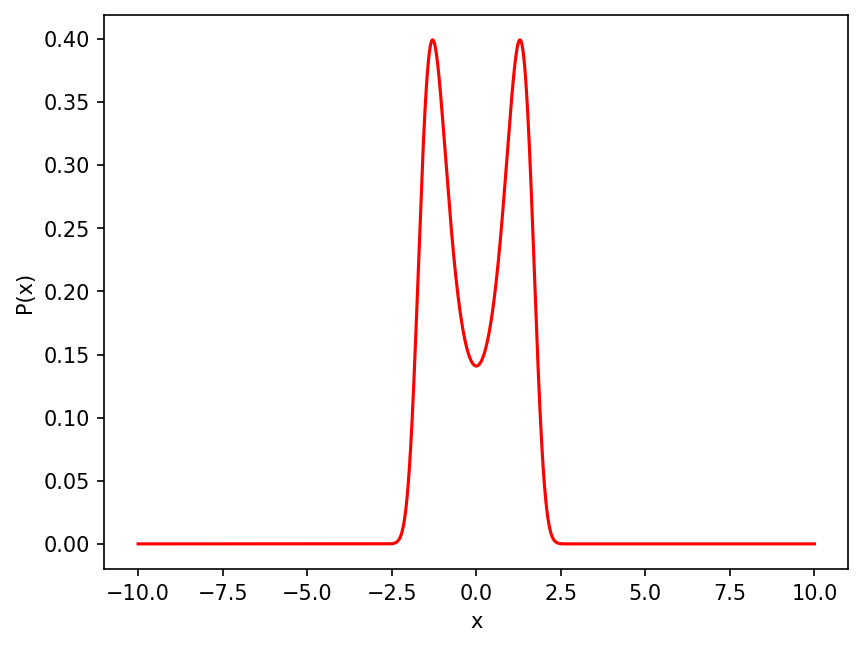

In [48]:
## Classical diagnonalization
A, P = la.eig(U)

A_real = np.real(A)
index = np.where(A_real == np.amax(A_real))[0][0]

eigenvalue = A[index]
zeromode_classic = P[:, index]

zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))

print("the available eigenvalues are: \n" + str(A))
print()

phases_classical = np.array([])

print("the phases are: ")

for z in A:
    a, phase = euler_representation(z)
    phases_classical = np.append(phases_classical, [phase])
    print(str(a) + " * exp(i *" + str(phase) + " )")
    print()
    
print('The calculated phases are:')
print(phases_classical)
print()

print("The minimum eigenvalue located is: \n" + str(eigenvalue))
print()

print("The minimum zeromode located is: \n" + str(np.real(zeromode_classic)))
    
# Estimating the probability of collapse into the zeromode
initial = np.zeros((P.shape[0], ))
initial[0] = 1
    
probability_zeromode, probability = analyze_collapse(initial, np.real(P), index)

# Printing out the spectrum of eigenvectors
print('The spectrum of eigenvectors is:' )
print(P)
print()

# Visualization of the ground state PDF (exact solution)
plt.figure(dpi = 150)
plt.plot(x, y, 'r')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

## Statistical results for the steady-state PDF

In [49]:
## Computation
classical_x_expectation, classical_x_square_expectation = get_expectation(x, y)
classical_deviation = np.sqrt(np.var(y))
classical_skewness = skew(y, bias = False)
classical_kurtosis = kurtosis(y)
classical_moments = get_moments(y, moments)

# Computing the CDF of the classical distribution
cum_classical = np.cumsum(y)
cum_classical = cum_classical/cum_classical[-1] # normalization

# Determining the maximas in the PDF
classical_max = get_maxima(x, y)

## Print all relevant results
# Print the standard deviation of the distribution
print('The standard deviation of the distribution is:')
print(classical_deviation)
print()

# Print the expectation value of x
print('The expectation value of x is:')
print(classical_x_expectation)
print()

# Print the expectation value of x^2
print('The expectation value of x^2 is:')
print(classical_x_square_expectation)
print()

# Print the skewness of the distribution 
print('The skewness of the distribution is:')
print(classical_skewness)
print()

# Print the kurtosis of the distribution
print('The kurtosis of the distribution is:')
print(classical_kurtosis)
print()

# Print the moments of the distribution
print('The moments of the distribution are:')
print(classical_moments)
print()

# Print the maxima value
print('The maxima(s) in the PDF occurs at x =')
print(classical_max)
print()

The standard deviation of the distribution is:
0.10812888193156592

The expectation value of x is:
-2.3603263571951676e-14

The expectation value of x^2 is:
138.56094953813795

The skewness of the distribution is:
2.0709695437567497

The kurtosis of the distribution is:
2.9492197395374973

The moments of the distribution are:
[0.0, 0.011691855107770521, 0.002616212028776786, 0.0008132552201772836, 0.00025005677183441736]

The maxima(s) in the PDF occurs at x =
1.2956478239119562



## Zeromode estimation using the VQSVD algorithm

### Ref.: Wang, X. et al. Quantum 5, 483 (2021)

In [50]:
# Hyperparameter settings
rank = dimension # rank of the matrix to be learned
itr = 200 # number of iterations
lr = 0.02 # learning rate
seed = 14 # random seed

# Set the learning weight 
weight = np.arange(3 * rank, 0, -3).astype('complex128')
print('The selected weight is:')
print(weight)

# Set circuit parameters
num_qubits = int(np.log2(dimension))               
depth = 70 # circuit depth

# Define the quantum neural network
def U_theta(num_qubits: int, depth: int) -> Circuit:

    # Initialize the network with Circuit
    cir = Circuit(num_qubits)
    
    # Build a hierarchy
    for _ in range(depth):
        cir.ry()
        cir.rz()
        cir.cnot()

    return cir

class VQSVD():
    def __init__(self, matrix: np.ndarray, weights: np.ndarray, num_qubits: int, depth: int, rank: int, lr: float, itr: int, \
                 seed: int):
        
        # Hyperparameters
        self.rank = rank
        self.lr = lr
        self.itr = itr
        
        paddle.seed(seed) # set a seed for better reproducibility of results
        
        # Create the parameter theta for learning W
        self.cir_W = U_theta(num_qubits, depth)
        
        # Create a parameter phi to learn V_dagger
        self.cir_V = U_theta(num_qubits, depth)
        
        # Convert Numpy array to Tensor supported in Paddle
        self.M = paddle.to_tensor(matrix)
        self.weight = paddle.to_tensor(weights)

    # Define the loss function
    def loss_func(self):
        
        # Get the unitary matrix representation of the quantum neural network
        W = self.cir_W.unitary_matrix()
        V = self.cir_V.unitary_matrix()
    
        # Initialize the loss function and singular value memory
        loss = paddle.to_tensor(0.0)
        singular_values = np.zeros(self.rank)
        
        # Define loss function
        for i in range(self.rank):
            loss -= paddle.real(self.weight)[i] * paddle.real(dagger(W) @ self.M @ V)[i][i]
            singular_values[i] = paddle.real(dagger(W) @ self.M @ V)[i][i].numpy()
        
        # Function returns learned singular values and loss function
        return loss, singular_values
    
    def get_matrix_U(self):
        # Function to retrieve the U matrix
        
        return self.cir_W.unitary_matrix()
    
    def get_matrix_V(self):
        # Function to retrieve the V_dagger matrix
        
        return self.cir_V.unitary_matrix()
    
    # Train the VQSVD network
    def train(self):
        loss_list, singular_value_list = [], []
        optimizer = paddle.optimizer.Adam(learning_rate=self.lr, parameters=self.cir_W.parameters()+self.cir_V.parameters())
        
        for itr in range(self.itr):
            loss, singular_values = self.loss_func()
            loss.backward()
            optimizer.minimize(loss)
            optimizer.clear_grad()
            loss_list.append(loss.numpy()[0])
            singular_value_list.append(singular_values)
#             if itr % 10 == 0:
#                 print('iter:', itr,'loss:','%.4f'% loss.numpy()[0])
                
        return loss_list, singular_value_list
    
def training_svd(matrix, weights, num_qubits, depth, rank, lr, itr, seed):
    # Function to perform the training of the dataset(s)
    # Note: training and minimization performed using the Adam optimizer
    
    # Initialization
    loss_list, singular_value_list = [], []
    U_learned, V_dagger_learned = [], []
    
    # Construct the VQSVD neural network and train the dataset
    net = VQSVD(matrix = matrix, weights = weights, num_qubits = num_qubits, depth = depth, rank = rank, lr = lr, itr = itr, \
                seed = seed)
    loss_list, singular_value_list = net.train() # train the dataset
    
    # Obtain the learned U and V_dagger matrices
    U_learned = net.get_matrix_U().numpy()
    V_dagger_learned = dagger(net.get_matrix_V()).numpy()
    
    # Extract the zeromode
    zeromode_trained_svd = V_dagger_learned[-1, :] # as the singular values are arranged in descending order
    
    # Check for signs (to maintain reproducibility)
    for val in zeromode_trained_svd:
        if val < 0:
            zeromode_trained_svd = -zeromode_trained_svd # per Python's convention
        break
    
    # Reshape the zeromode as a column vector for better visualization and/or comparison
    zeromode_trained_svd = np.reshape(zeromode_trained_svd, (zeromode_trained_svd.shape[0], 1))
    zeromode_trained_svd = np.real(zeromode_trained_svd) # we're only interested in the real part
    
    # Compute the probability of collapsing into each basis state
    zeromode_prob = []
    for val in zeromode_trained_svd:
        zeromode_prob.append(abs(val) ** 2) # absolute square of the amplitudes
    
    return U_learned, V_dagger_learned, zeromode_trained_svd, zeromode_prob, singular_value_list, loss_list

The selected weight is:
[24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]


## Quantum analysis

### Running VQSVD

In [51]:
## Analysis using the VQSVD algorithm
# Get the required matrix
min_eigenvalue = 1
matrix = U - min_eigenvalue * np.identity(dimension)
    
# Train the dataset and obtain the required outcomes
U_learned, V_dagger_learned, zeromode_trained_svd, zeromode_prob, singular_value_list, loss_list = training_svd(matrix = matrix, \
                                                                                                 weights = weight, \
                                                                                                 num_qubits = num_qubits, depth = depth, \
                                                                                                 rank = rank, lr = lr, itr = itr, \
                                                                                                 seed = seed)

# Compute the cosine similarity between the classical and VQSVD zeromodes
similarity = get_similarity(zeromode_classic, zeromode_trained_svd, runit = 4)
overlap = get_overlap(zeromode_classic, zeromode_trained_svd, runit = 4)
distance = euclidean_distance(zeromode_classic, zeromode_trained_svd, runit = 4)

## Printing out VQSVD results

In [52]:
## Print all relevant results
# Print the zeromode
print('The zeromode obtained using the VQSVD algorithm is:')
print(zeromode_trained_svd)
print()

# Print the probability of collapsing into each basis state
print('The probability of collapsing into each basis state is:')
print(zeromode_prob)
print()

# Print the similarity score
print('The fidelity between the classical and VQSVD zeromodes is:')
print(similarity)
print()

# Print the overlap
print('The overlap between the classical and VQSVD zeromodes is:')
print(overlap)
print()

# Print the Euclidean distance
print('The Euclidean distance between the classical and VQSVD zeromodes is:')
print(distance)
print()

The zeromode obtained using the VQSVD algorithm is:
[[ 0.44663134]
 [ 0.56923604]
 [ 0.52637273]
 [ 0.27406627]
 [ 0.03572845]
 [-0.04070639]
 [-0.01230786]
 [ 0.00883696]]

The probability of collapsing into each basis state is:
[array([0.19947955], dtype=float32), array([0.32402968], dtype=float32), array([0.27706826], dtype=float32), array([0.07511232], dtype=float32), array([0.00127652], dtype=float32), array([0.00165701], dtype=float32), array([0.00015148], dtype=float32), array([7.8091834e-05], dtype=float32)]

The fidelity between the classical and VQSVD zeromodes is:
0.9999821048528396

The overlap between the classical and VQSVD zeromodes is:
0.9374657309886067

The Euclidean distance between the classical and VQSVD zeromodes is:
[0.06283542]



## Plotting the loss curve

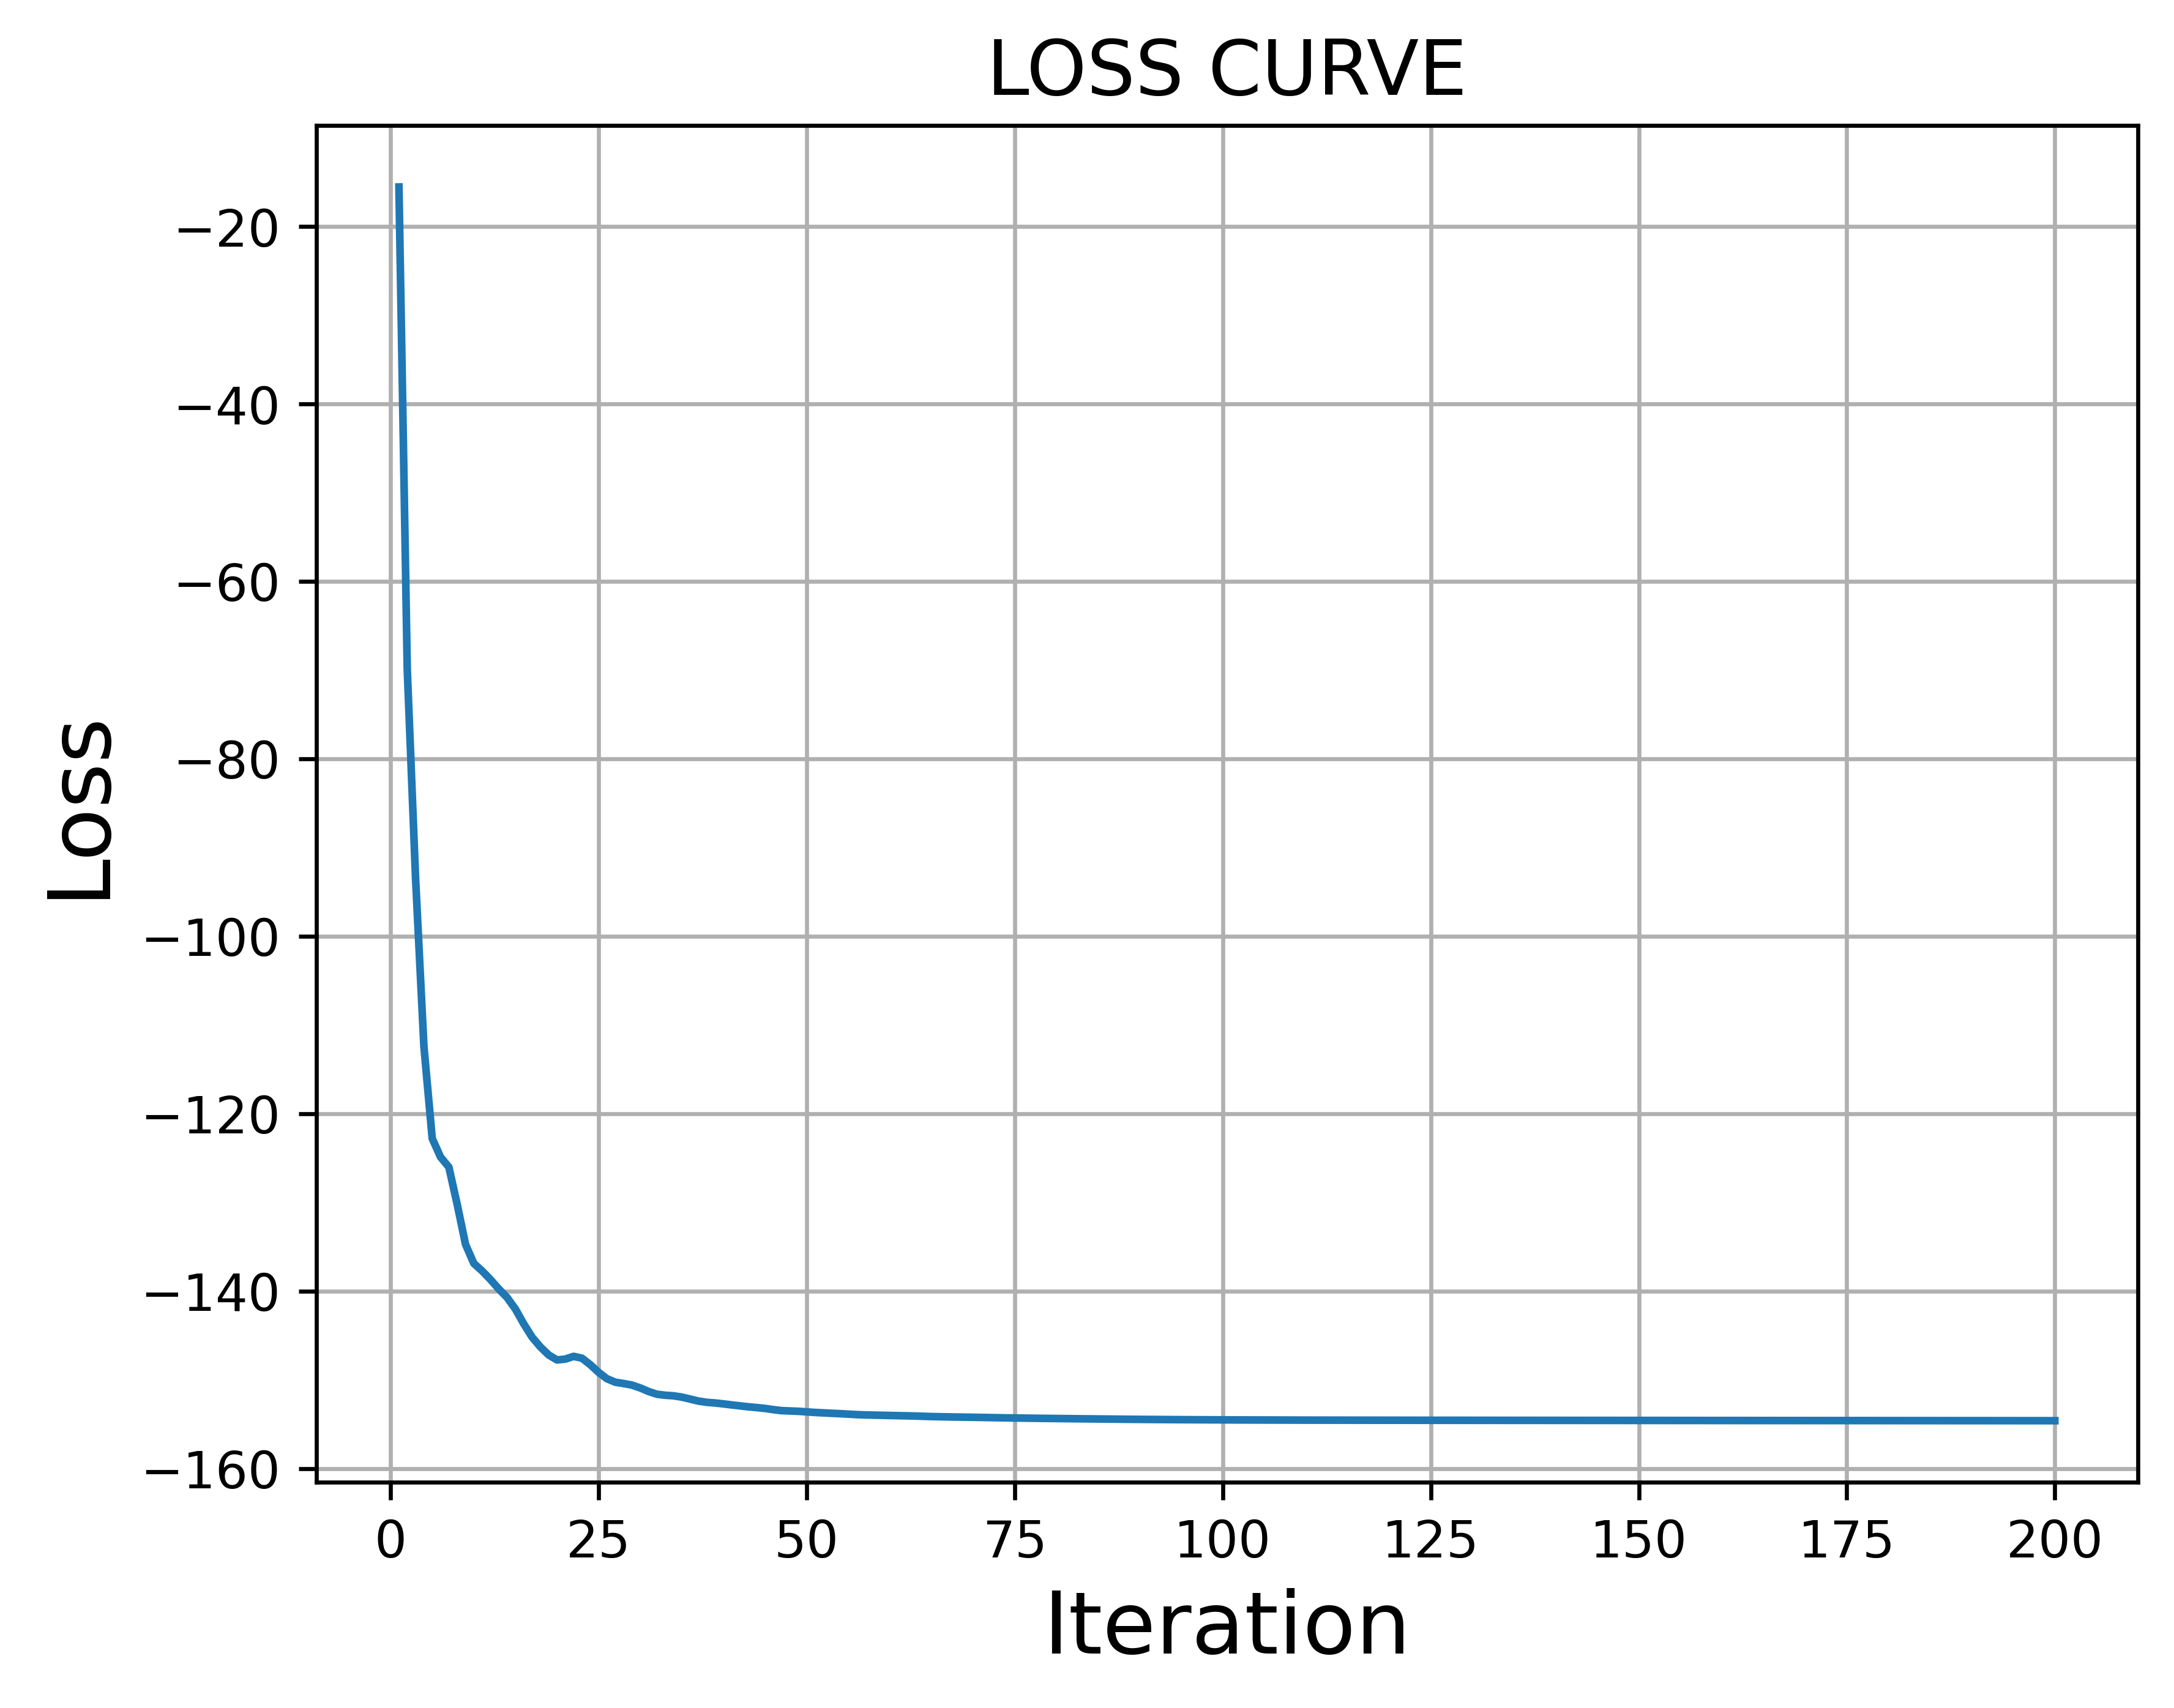

In [53]:
## Plotting a loss curve for visualization
x_axis = range(1, len(loss_list) + 1)

plt.figure(dpi = 600)
plt.plot(list(x_axis), loss_list)
plt.xlabel('Iteration', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)
plt.title('LOSS CURVE', fontsize = 15)
plt.grid(True)

plt.show()

## Error analysis data and plots

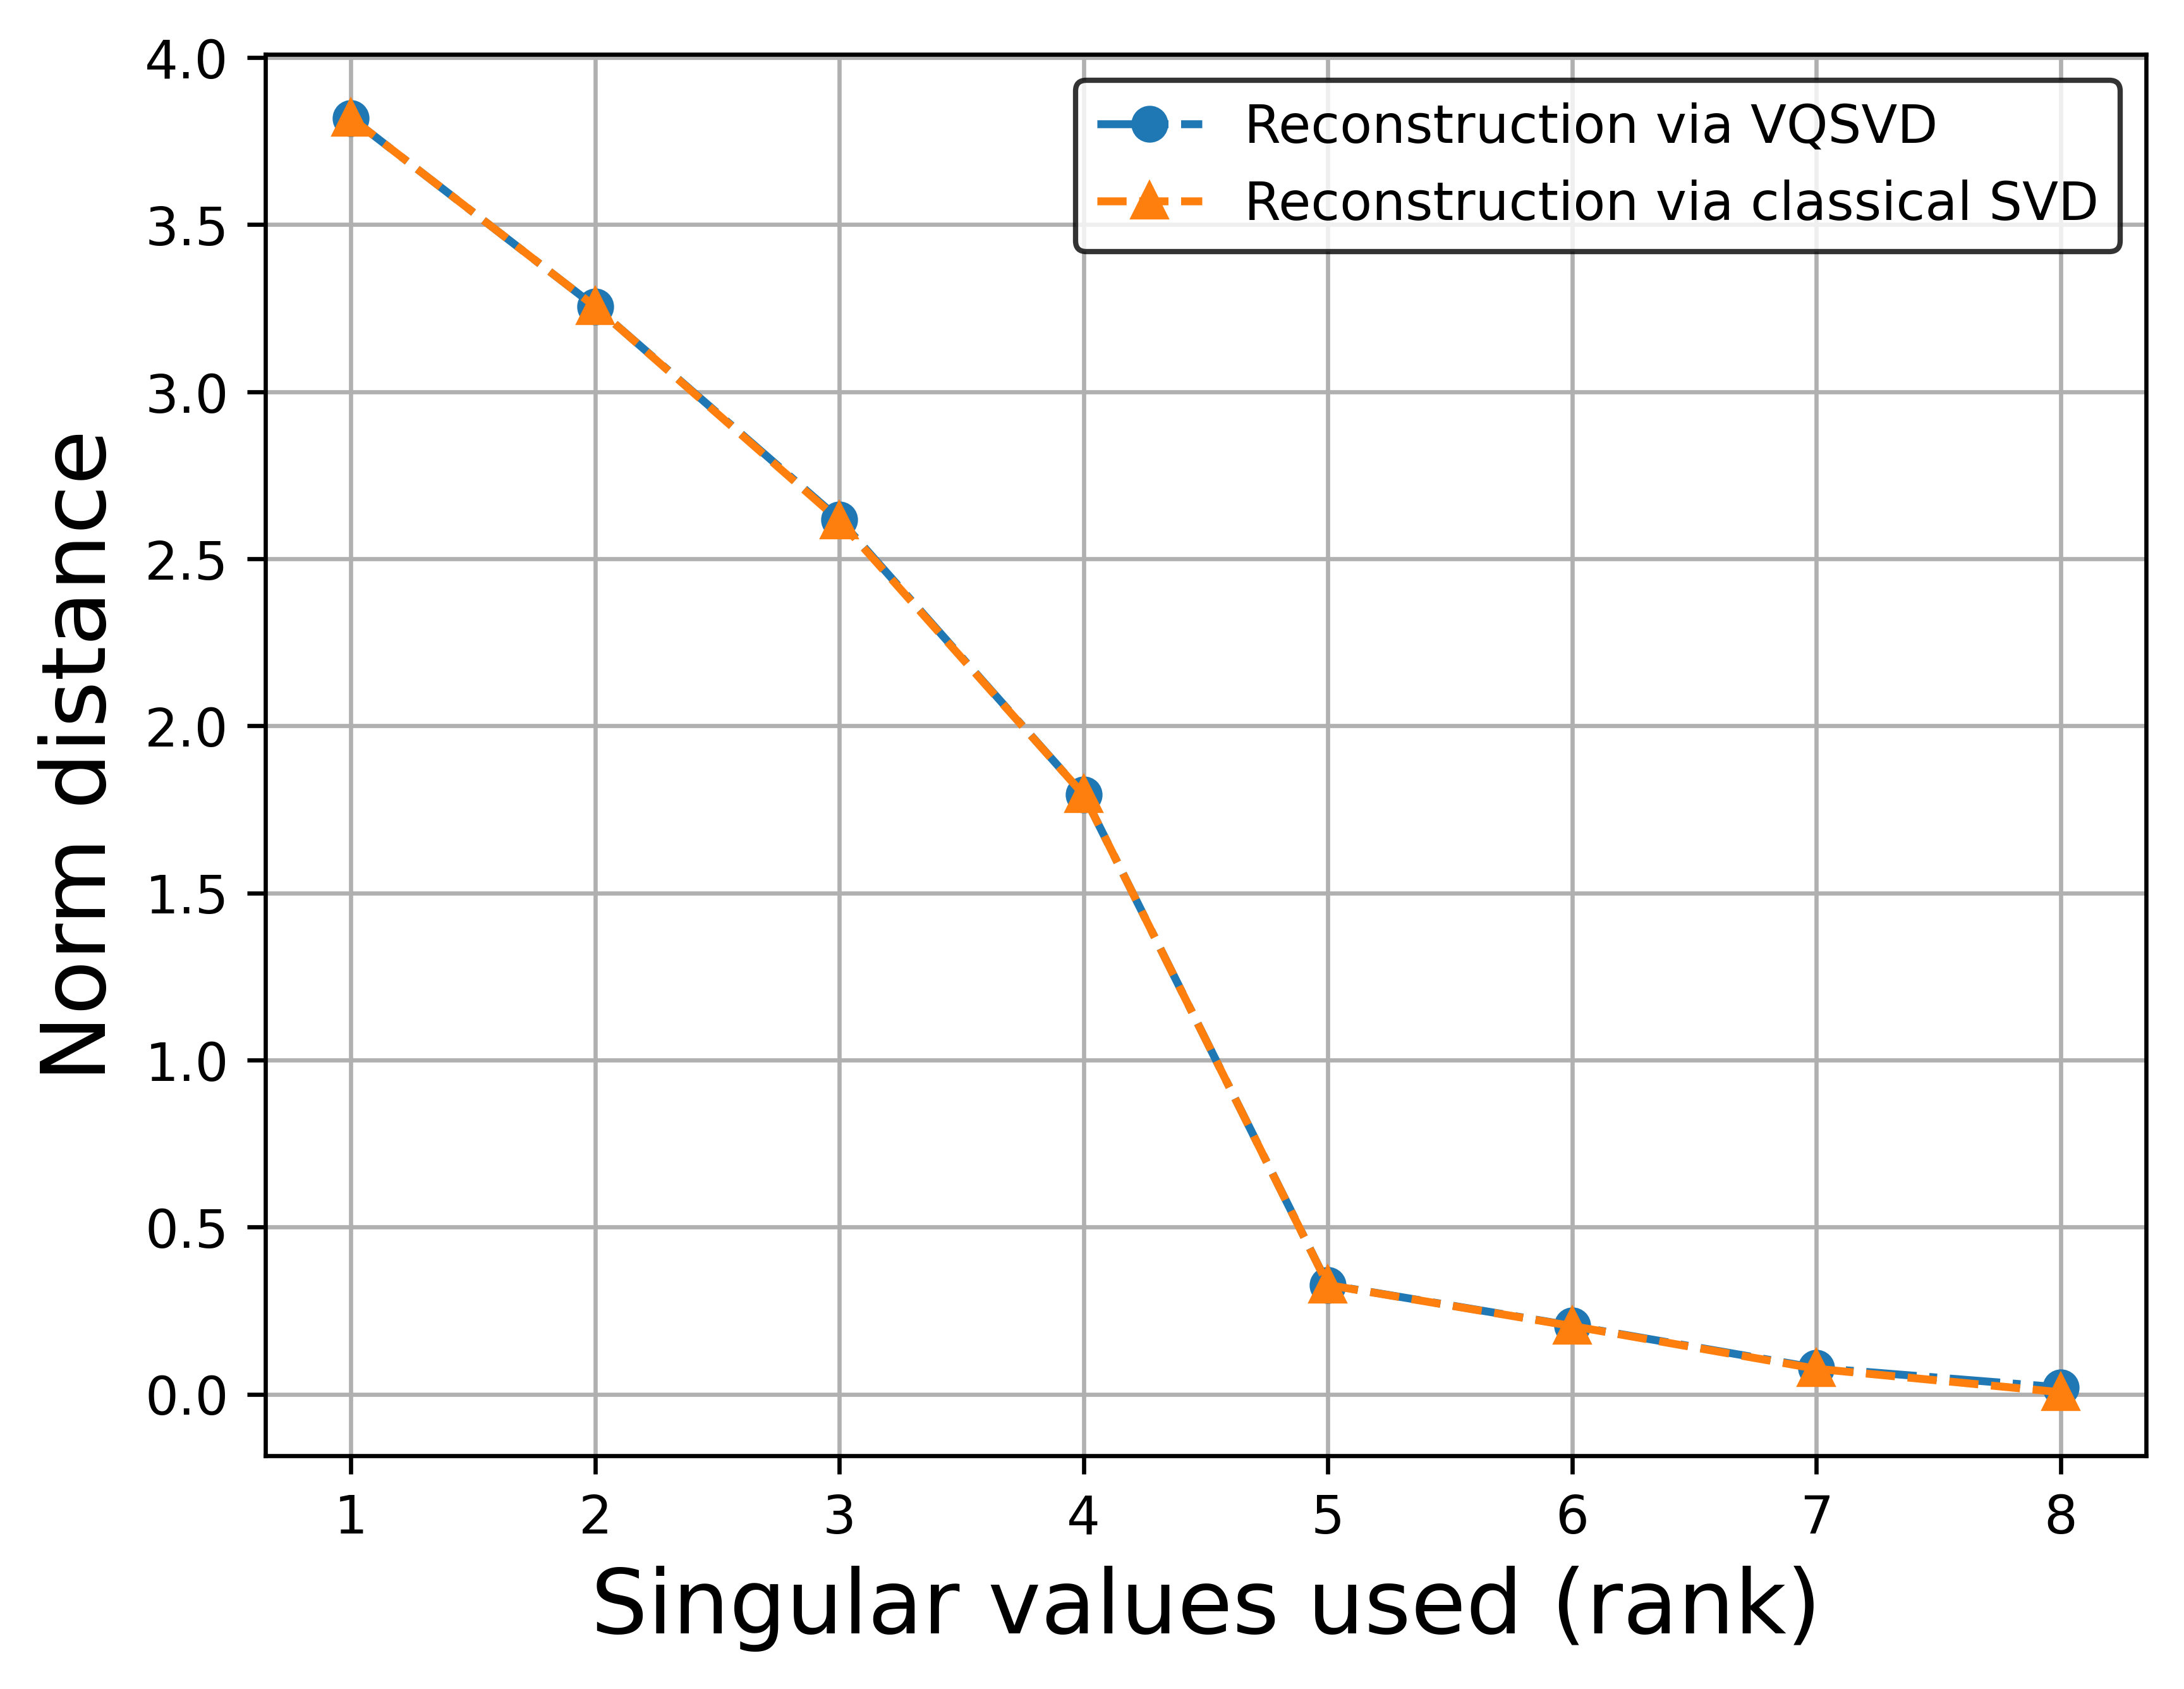

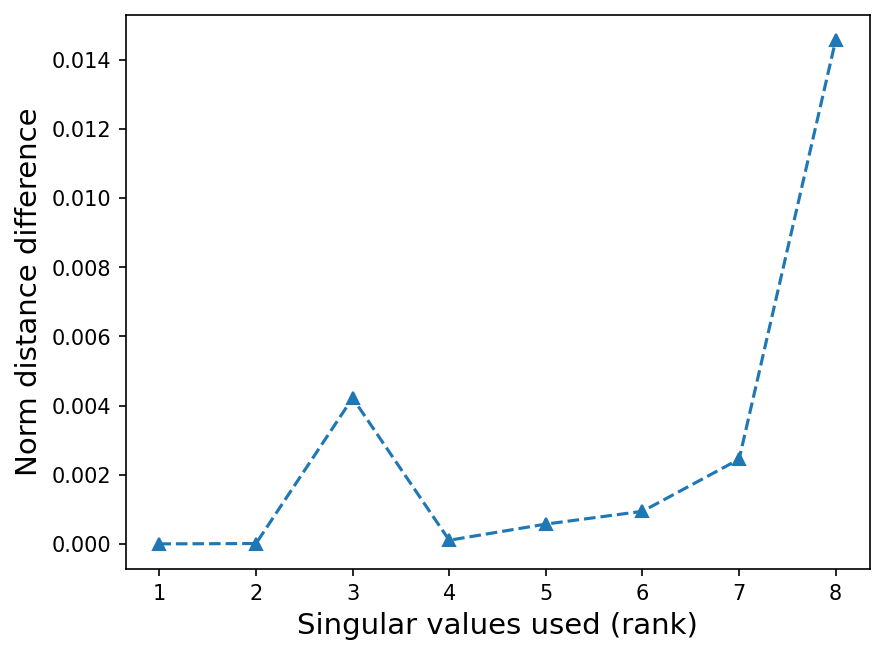

The SVD errors using VQSVD are:
[3.819637880047409, 3.2546918969530734, 2.618083591424433, 1.7937555444515534, 0.3272868164104926, 0.2047395244796873, 0.07840072783839493, 0.020317241610610978]

The SVD errors using classical SVD are:
[3.819637880047409, 3.2546819733775836, 2.6138650919889024, 1.793649881941201, 0.3267143222693442, 0.20379760129019595, 0.0759521046544124, 0.005739696516386433]



In [54]:
## Error analysis (Frobenius norm)
err_subfull, err_local, err_SVD = error_analysis(U, min_eigenvalue, U_learned, V_dagger_learned, singular_value_list, \
                                                 rank = rank)

## Print all relevant results
# Print the local errors
print('The SVD errors using VQSVD are:')
print(err_subfull)
print()

# Print the SVD errors
print('The SVD errors using classical SVD are:')
print(err_SVD)
print()

## Computing the steady-state PDF

The standard deviation of the distribution is:
0.1081950522675666

The expectation value of x is:
-1.4513025925680206e-14

The expectation value of x^2 is:
136.5359459407542

The skewness of the distribution is:
2.0636130750815886

The kurtosis of the distribution is:
2.9158941297172456

The moments of the distribution are:
[0.0, 0.011706169335181467, 0.0026117076613712004, 0.0008106810055105978, 0.00024895316295810366]

The mean of the PDF estimated using VQSVD is:
0.04999999999999999

The variance of the PDF estimated using VQSVD is:
0.011706169335181467

The error in estimating the mean is (percentage):
0.00249999999986511

The error in estimating the variance is (percentage):
0.0014314227410945624



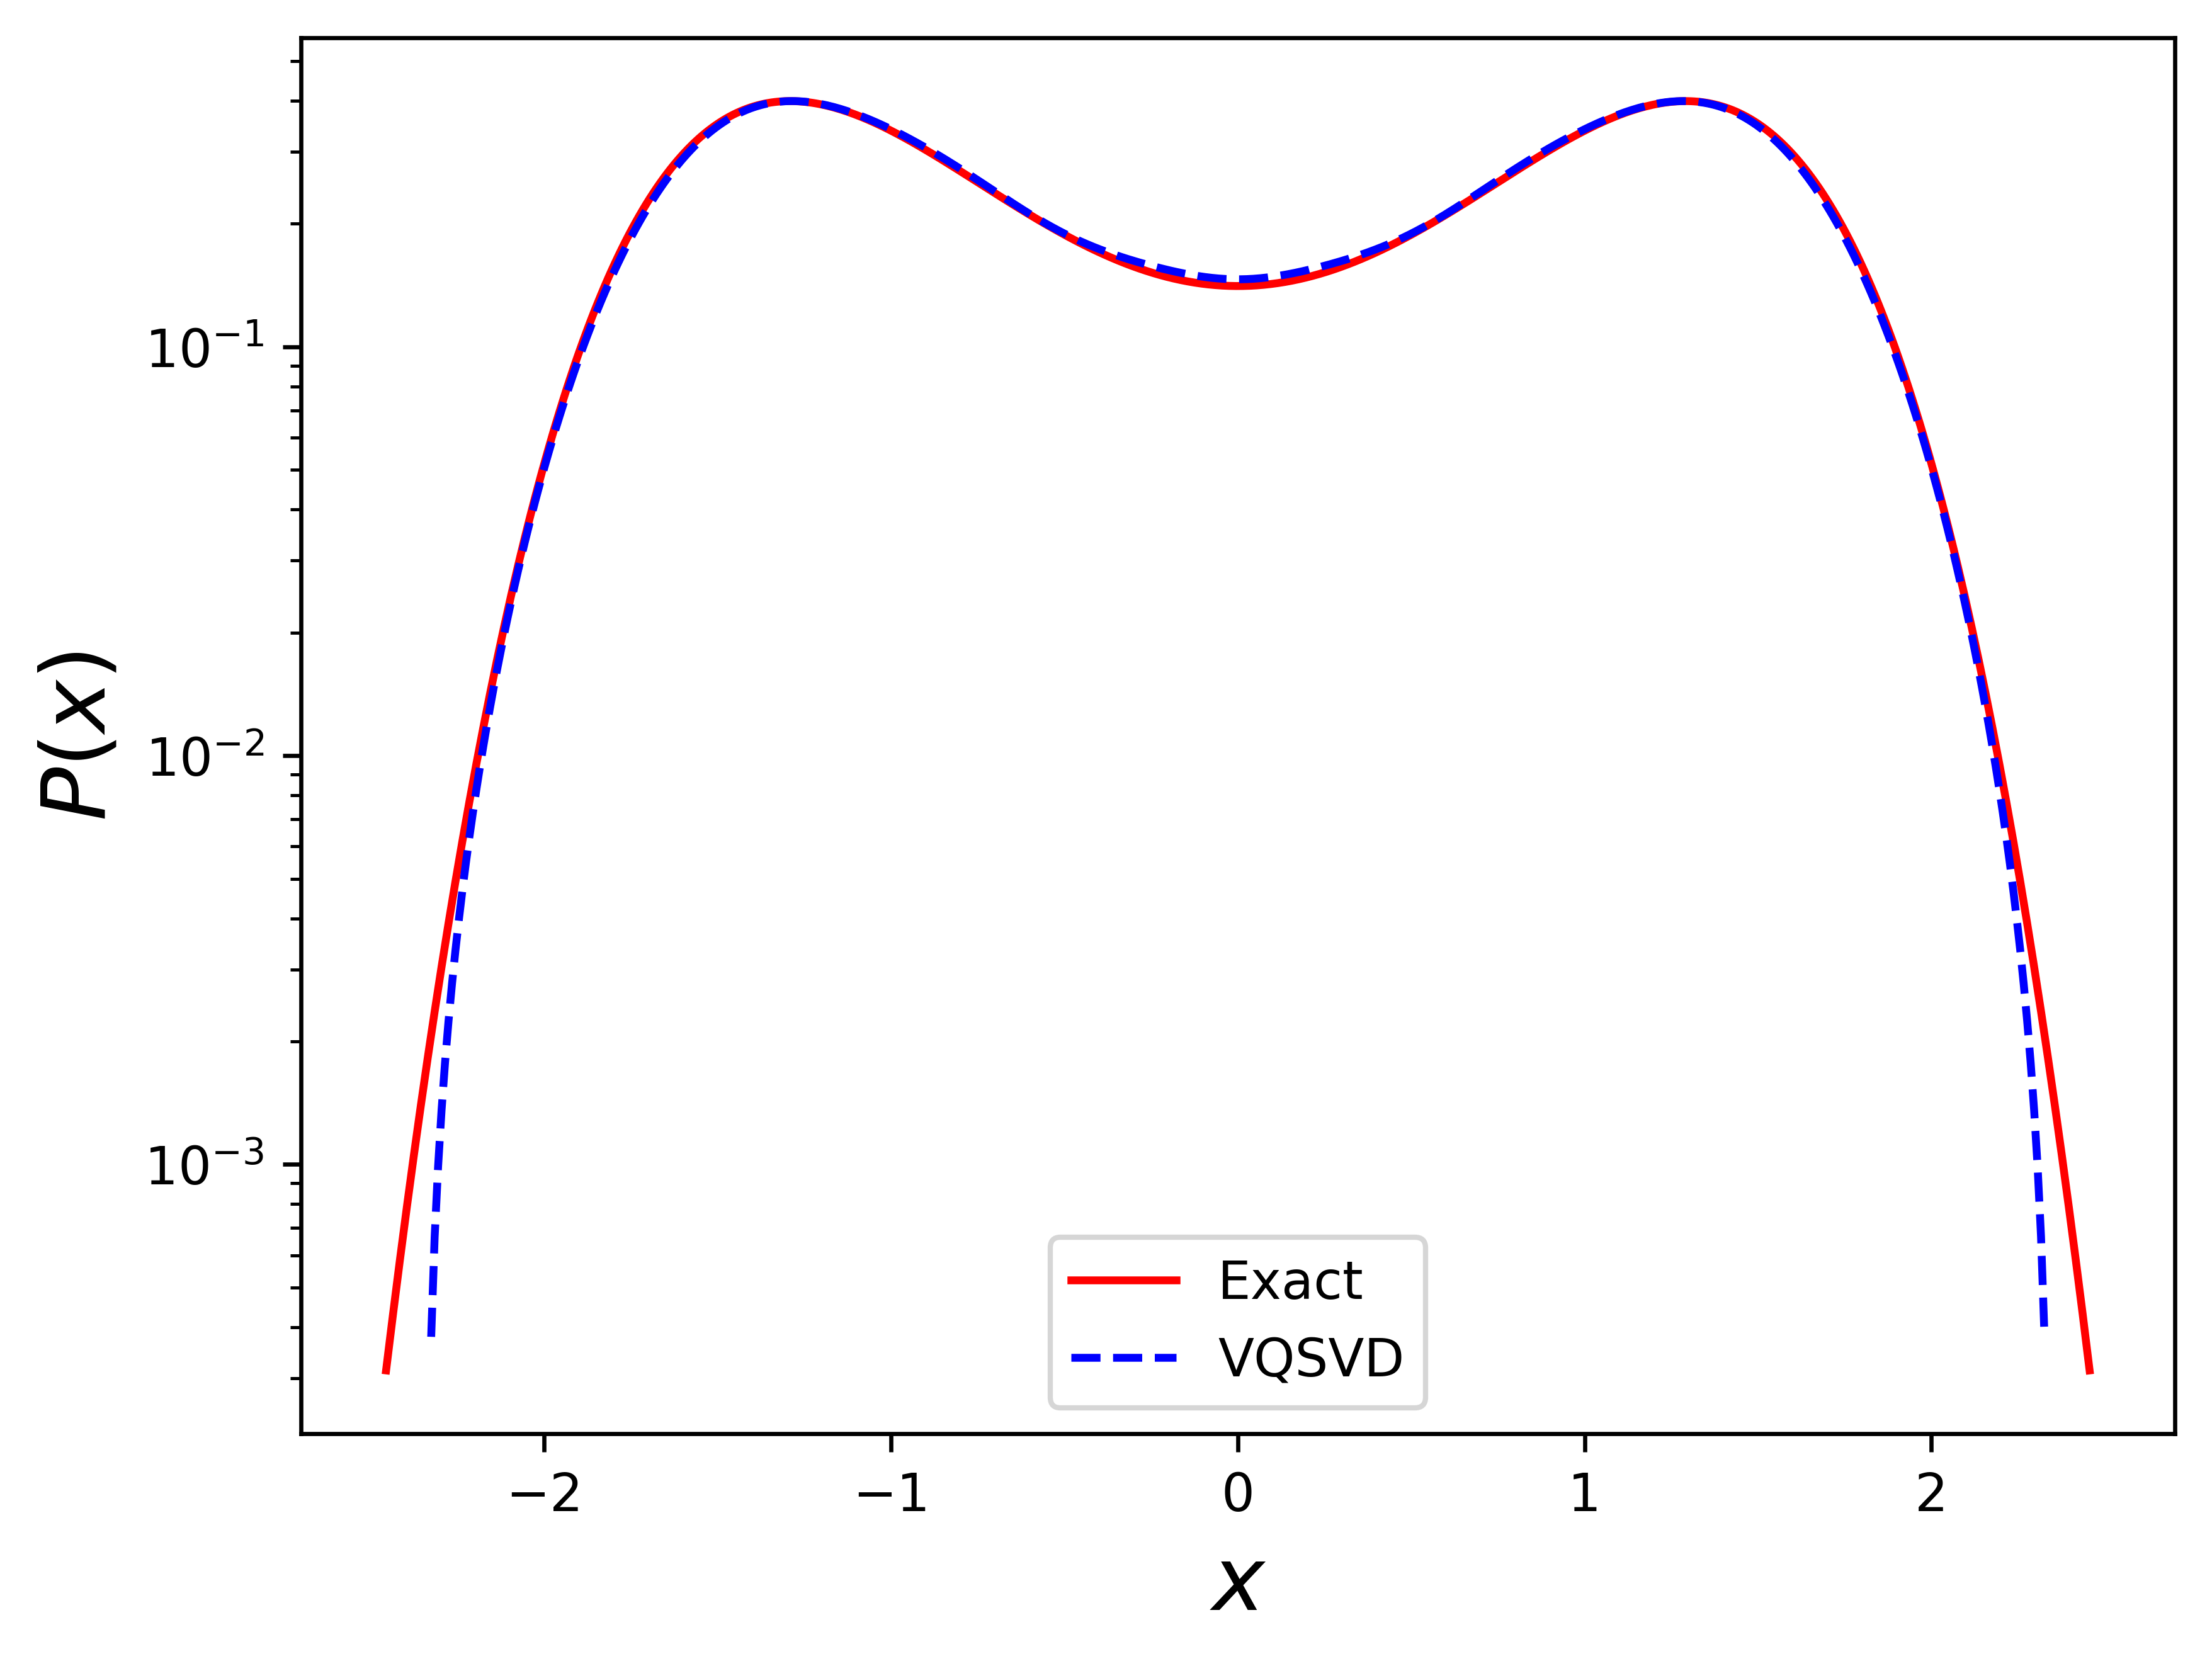

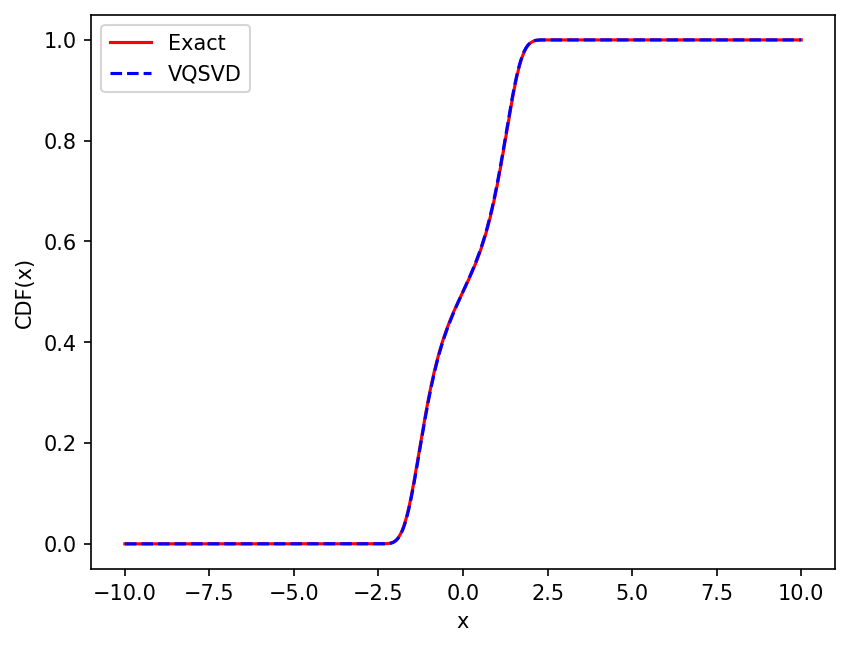

In [56]:
## Get the ground state PDF using the VQSVD zeromode
x_qpe, y_qpe = get_pdf(nmax, x, dx, L, shift, zeromode_trained_svd, normalize = True, make_even = True)

# Compute the standard deviation of the distribution
deviation = np.sqrt(np.var(y_qpe))

# Compute the expectation value of x
x_expectation, x_square_expectation = get_expectation(x, y_qpe)

# Compute the skewness and kurtosis of the distribution
skewness = skew(y_qpe, bias = False)
kurtosis_val = kurtosis(y_qpe)

# Compute the moments of the distribution
quantum_moments = get_moments(y_qpe, moments)

# Compute the quantum CDF
cum_quantum = np.cumsum(y_qpe)
cum_quantum = cum_quantum/cum_quantum[-1] # normalization

# Compute the mean and variance of the distribution
mean_dis = np.mean(y_qpe)
variance = np.var(y_qpe)

# Compute the absolute error percentage in estimating the mean and variance
error_mean = abs(mean_dis - np.mean(y)) * 100
error_variance = abs(variance - np.var(y)) * 100

## Print the relevant results
# Print the standard deviation
print('The standard deviation of the distribution is:')
print(deviation)
print()

# Print the expectation value
print('The expectation value of x is:')
print(x_expectation)
print()

# Print the expectation value of x^2
print('The expectation value of x^2 is:')
print(x_square_expectation)
print()

# Print the skewness of the distribution
print('The skewness of the distribution is:')
print(skewness)
print()

# Print the kurtosis of the distribution
print('The kurtosis of the distribution is:')
print(kurtosis_val)
print()

# Print the moments of the distribution
print('The moments of the distribution are:')
print(quantum_moments)
print()

# Print the mean
print('The mean of the PDF estimated using VQSVD is:')
print(mean_dis)
print()

# Print the variance
print('The variance of the PDF estimated using VQSVD is:')
print(variance)
print()

# Print the error in estimating the mean
print('The error in estimating the mean is (percentage):')
print(error_mean)
print()

# Print the error in estimating the variance
print('The error in estimating the variance is (percentage):')
print(error_variance)
print()

# Comparison between the ground state PDFs (on a log scale)
y_cutoff = 3 * 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff)
x_quantum, y_quantum = cutoff_graph(x, y_qpe, y_cutoff)

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, 'r', label = 'Exact')

# Plot the second set of data on a log base 2 scale
ax.plot(x_quantum, y_quantum, 'b--', label = 'VQSVD')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

# Comparison between the classial and VQSVD CDFs
plt.figure(dpi = 150)
plt.xlabel('x')
plt.ylabel('CDF(x)')

plt.plot(x, cum_classical, 'r', label = "Exact")

plt.plot(x, cum_quantum, 'b--', label = "VQSVD")

plt.legend()